1. setup pipeline
2. FIRST USECASE: login via spotify, enter a playlist, it plays the (15sec) popular moments as a medley
    * deploy via streamlit and github
    * everything gets downloaded for 2nd UC
    * store in AWS DB
3. apply ML
4. SECOND USECASE: predict popular moments

## TODO

bugs
* last song keeps playing until the end

add features
* database
* asyncronicity
* yt get video in tabs concurrently
* match beats via spotify and choose the play order
* let users login on their own spotify

tinkering
* yt search takes only the first search result
* search for 'pass' and do something about it
* detect captchas
* pandadise: proxy file
* ProxyServer: maintain a list of burned/banned proxies
* refresh spotify token for playback sdk

# ML

## Research

* BERT for Lyrics

Musing about my use case:
* Regression because I need a timestamp/real number that I can scale to a timestamp
* Timeseries: I got several (seemingly) unrelated, small timeseries with a number of features for each timestamp
* not one continuous timeseries https://www.quora.com/What-is-the-difference-between-time-series-analysis-and-longitudinal-data-analysis?share=1
* not like release year prediction where one profile is associated to a year; here the progress of the features determines a timestamp, but if that same progress would appear later in a song instead it would be a different timestamp
* what had been done: genre, popularity/hit or not/charts position prediction
* one question about my case; with no answers: https://datascience.stackexchange.com/questions/42137/how-to-train-a-model-to-predict-a-time-window-than-an-event-will-occur-on-a-webs
* this https://stats.stackexchange.com/questions/564867/multiple-time-series-forecasting-how-to-split-the-data-for-training-of-a-neural says to make all series use the same timestamps (put them together) but that missing data in one of the dimensions would cause troubles ---> I would have missing data since I needed to scale the track duration uniformly but would then have different densities for features

* extended explanation for everything related to timeseries their concepts and methods:
    * https://neptune.ai/blog/select-model-for-time-series-prediction-task
    * https://blog.paperspace.com/introduction-time-series-analysis/
* multivariate timeseries (several features)
* trends, seasonality, noise, autocorrelation
* timeseries only about forecasting or can I also model the series? https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe

* possible models:
    * RandomForest (has better performance than a single tree and has weaker performance than ensemble methods which are designed to reduce the bias error)
    * Guide https://www.pluralsight.com/guides/machine-learning-for-time-series-data-in-python
    * XGBoost Regression
* CV:
    * sliding-window 
    * Forward Chaining validation
    * see here https://towardsdatascience.com/time-series-machine-learning-regression-framework-9ea33929009a
* metrics:
    * Mean Square Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Root Mean Squared Log Error (RMSLE), R-squared

## Construct features

### Gather Data

In [1]:
async def setup():
    # setting up spotify
    import os 
    from src.SpotifyHandler import SpotifyHandler
    from src.AsyncHandler import AsyncHandler
    ash = AsyncHandler()

    sp_handler = SpotifyHandler(ash, os.path.join(os.getcwd(), '.env_spotify'))

    # setting up youtube
    from src.RequestsYTHandler import RequestsYTHandler
    yt_handler = RequestsYTHandler(_async_handler = ash)

    from asyncio import create_task as asyncio_create_task
    await asyncio_create_task(yt_handler.setup())

    # setting up mysql
    from src.utils import MyMySQLConnection, ConfigHandler

    relative_path_to_file = '.env_mysql'
    keys = ConfigHandler(relative_path_to_file)
    sql_cred_dict = keys.load_config('SQL')
    db_name = 'songs'
    sql_handler = MyMySQLConnection(sql_cred_dict, db_name)

    from src.utils import PrintLogger
    info = PrintLogger.register('Notebook')

    return sp_handler, yt_handler, sql_handler, info

In [2]:
def get_audio_features(sp_handler, track_uri):
    track_aanal = sp_handler.retrieve('audio_analysis', track_uri)  
    
    from src.utils import intersect_cols
    shared, only_sections, only_segments = intersect_cols(
                                                track_aanal['segments'][0].keys(),
                                                track_aanal['sections'][0].keys(),
                                                'yes'
                                            )
    
    from pandas import json_normalize as pd_json_normalize

    df_segments = pd_json_normalize(track_aanal['segments'])
    df_sections = pd_json_normalize(track_aanal['sections'])

    # splitting pitches and timbre
    from pandas import DataFrame as pd_DataFrame

    cols = list(map(lambda x: 'chroma' + str(x), range(12)))
    df_segments[cols] = pd_DataFrame(df_segments['pitches'].tolist(), index= df_segments.index)

    cols = list(map(lambda x: 'timbre' + str(x), range(12)))
    df_segments[cols] = pd_DataFrame(df_segments['timbre'].tolist(), index= df_segments.index)

    df_segments.drop(columns=['pitches', 'timbre'], inplace=True)

    # add section information to respective segments
    df_sections['end'] = df_sections['start'] + df_sections['duration']
    df_merged = df_sections.merge(right = df_segments, how = 'cross', suffixes = ('_sec', '_seg'))
    mask = (df_merged['start_seg'] >= df_merged['start_sec']) & (df_merged['start_seg'] <= df_merged['end'])

    df_segments = df_merged[mask].drop(columns = ['start_sec', 'duration_sec', 'confidence_sec', 'end'])

    # key and mode is a reserved keyword in mysql
    rename_dict = {'mode' : 'music_mode', 'key' : 'music_key'} 
    df_segments.rename(columns = rename_dict, inplace = True)
    return df_segments


In [3]:
def construct_dfs(
                    pl_uri,
                    deleted_tracks,
                    track_uri, 
                    track_names, 
                    track_artists, 
                    track_duration, 
                    track_popularity,
                    audio_list,
                    youtube_list
                ):

    from pandas import DataFrame as pd_DataFrame
    from pandas import concat as pd_concat

    df_tmp = pd_DataFrame(data = youtube_list, columns = ['yt_id', 'yt_name', 'mostReplayed'])
    
    tracks_dict = {
        'sp_uris': track_uri, 
        'sp_names': track_names, 
        'sp_artists': track_artists, 
        'sp_durations': track_duration, 
        'sp_popularities': track_popularity}
    df_tracks = pd_DataFrame(data = tracks_dict)
    df_tracks[['yt_id', 'yt_name']] = df_tmp[['yt_id', 'yt_name']]

    audio_list = [aa.assign(sp_uri = track_uri[i]) for i, aa in enumerate(audio_list)]
    df_audio_anals = pd_concat(audio_list)
    
    mostReplayed_labels = ['mostReplayed_label' + str(i) for i in range(98)]
    df_pl_tracks = pd_DataFrame(df_tmp['mostReplayed'].tolist(), columns = mostReplayed_labels)
    checked_out_tracks = track_uri + deleted_tracks
    df_pl_tracks = (
                        df_pl_tracks
                        .assign(pl_uris = [pl_uri] * len(checked_out_tracks))
                        .assign(track_uris = checked_out_tracks)
                        .assign(included = (['yes'] * len(track_uri)) + (['no'] * len(deleted_tracks)))
                    )
    
    return df_tracks, df_audio_anals, df_pl_tracks

In [14]:
def create_tables(sql_handler, table_names, cols):
    # creating sql tables
    tracks_dict = {table_names['tracks']: (cols['tracks'], 
                    ['varchar(256) NOT NULL, PRIMARY KEY (sp_uris)', #uri
                    'varchar(255) NOT NULL',       #name 
                    'varchar(255)',                #artists
                    'int',                         #duration in ms
                    'int',                     #popularities
                    'varchar(255)',               #yt_id
                    'varchar(255)']) }            #yt_name

    playlists_dict = {table_names['pl']: (cols['pl'], 
                    ['varchar(256) NOT NULL, PRIMARY KEY (pl_uris)', #pl_uris
                    'varchar(255) NOT NULL',       #pl_names 
                    'varchar(255)',                #pl_image_urls
                    'int']) }                   #pl_track_total         
    
    audio_anal_dict = {table_names['aa']: (cols['aa'], 
                    ['varchar(256)', #sp_uri
                    'FLOAT(40)',               #loudness 
                    'FLOAT(40)',               #tempo
                    'FLOAT(40)',               #tempo_confidence
                    'tinyint',                  #key
                    'FLOAT(40)',               #key_confidence
                    'tinyint',                  #mode 
                    'FLOAT(40)',               #mode_confidence
                    'tinyint',                  #time_signature
                    'FLOAT(40)',               #time_signature_confidence
                    'FLOAT(40)',               #start_seg
                    'FLOAT(40)',               #duration_seg 
                    'FLOAT(40)',               #confidence_seg
                    'FLOAT(40)',               #loudness_start
                    'FLOAT(40)',               #loudness_max_time
                    'FLOAT(40)',               #loudness_max
                    'FLOAT(40)'])}            #loudness_end
    audio_anal_dict[table_names['aa']][1].extend(['FLOAT(40)'] * 24)
                                           #chroma0..11, timbre0..11
                                
    
    pl_tracks_dict = {table_names['pl_tracks']: (cols['pl_tracks'], 
                    ['varchar(256) NOT NULL',    #sp_uri
                    'varchar(256) NOT NULL',      #pl_uri 
                    'varchar(256)']) }              #included
    pl_tracks_dict[table_names['pl_tracks']][1].extend(['FLOAT(40)'] * 98)
                                            #mostReplayed_label0..97
    
    tables = {**tracks_dict, **playlists_dict, **audio_anal_dict, **pl_tracks_dict}
    sql_handler.create_tables(tables)
    

In [5]:
sp_handler, yt_handler, sql_handler, info = await setup()
are_tables_created = False
table_names = {
    'tracks' : 'tracks', 
    'pl': 'playlists', 
    'aa': 'audio_analysis', 
    'pl_tracks': 'playlists_tracks'
}


-+-+ This is SpotifyHandler registring.
- + - +  This is AsyncHandler registring.
-  +  -  +   This is RequestsYTHandler registring.
-  +  -  +   RequestsYTHandler:  Starting Proxy Server
-   +   -   +    This is ProxyServer registring.
-   +   -   +    ProxyServer:  Searching for new proxies.
- + - +  AsyncHandler:  Creating task (<coroutine object Broker.find at 0x000001668D628D40>,)
-  +  -  +   RequestsYTHandler:  Waiting for Proxy Server
-   +   -   +    ProxyServer:  Proxy queue has currently 0 items.
-   +   -   +    ProxyServer:  Waiting to receive proxies.
-  +  -  +   RequestsYTHandler:  Got a Proxy
-  +  -  +   RequestsYTHandler:  Using proxy = https://213.32.75.44:9300.
-  +  -  +   RequestsYTHandler:  Using user-agent Mozilla/5.0 (X11; OpenBSD i386) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36.
-    +    -    +     This is Notebook registring.


In [6]:
# gathering data
query = 'top'
from src.utils import PrintLogger

with info('Get Playlists'):
    pl_uri, pl_names, pl_image_url, pl_track_total = sp_handler.search_playlist(query)

for pl_counter, pl in enumerate(pl_uri):
    with info(f'Get {pl_track_total[pl_counter]} Tracks for PL {PrintLogger.BOLD}{pl_names[pl_counter]}.'):
        track_uri, track_names, track_artists, track_duration, track_popularity = sp_handler.get_playlist_tracks(pl)
    with info(f'Get Audio Analysis for PL {pl_names[pl_counter]}'):
        audio_list = [get_audio_features(sp_handler, uri) for uri in track_uri]
    
    youtube_list = []
    del_track_idx = []
    with info(f'Get MostReplayed for PL {pl_names[pl_counter]}'):
        for i, name in enumerate(track_names):
            graph = None
            skip_ids = []
            while (not graph):
                query = name + '+' + track_artists[i] + '+' + 'official'
                try:
                    vid_id, vid_name = yt_handler.search(query, skip_ids = skip_ids)
                except Exception as e:
                    info().log(f'Got an exception for {query=}, {skip_ids=}. {PrintLogger.BOLD}Trying again')
                    vid_id, vid_name = yt_handler.search(query, skip_ids = skip_ids)
                    
                # break condition; search is exhausted
                if not vid_id:
                    del_track_idx.append(i)
                    break
                
                from asyncio import create_task as asyncio_create_task
                graph = await asyncio_create_task(yt_handler.get_most_replayed(vid_id, track_duration[i]))
                if graph:
                    youtube_list.append([vid_id, vid_name, graph['y']])
                else:
                    # video did not have a most replayed graph; keep searching but skip already tried video
                    skip_ids.append(vid_id)

    deleted_tracks = []
    for i in del_track_idx:
        deleted_tracks.append(track_uri[i])
        del track_uri[i]
        del track_names[i]
        del track_artists[i]
        del track_duration[i]
        del track_popularity[i]
        del audio_list[i]
        
    with info(f'Construct DataFrames PL {pl_names[pl_counter]}'):
        df_tracks, df_audio_anals, df_pl_tracks = construct_dfs(
                                                        pl_uri[pl_counter],
                                                        deleted_tracks,
                                                        track_uri, 
                                                        track_names, 
                                                        track_artists, 
                                                        track_duration, 
                                                        track_popularity,
                                                        audio_list,
                                                        youtube_list
                                                    )
    
    if not are_tables_created:
        cols = {
            'tracks' : df_tracks.columns.tolist(), 
            'aa' : df_audio_anals.columns.tolist(), 
            'pl' : ['pl_uris', 'pl_names', 'pl_image_urls', 'pl_track_total'],
            'pl_tracks' : df_pl_tracks.columns.tolist()
        }
        with info(f'Create Data Base Tables'):
            create_tables(sql_handler, table_names, cols)
        are_tables_created = True
        
    with info(f'Save Data for PL {pl_names[pl_counter]}'):   
        from pandas import DataFrame as pd_DataFrame
        pl_dict = {
            'pl_uris': pl_uri[pl_counter], 
            'pl_names': pl_names[pl_counter], 
            'pl_image_urls': pl_image_url[pl_counter], 
            'pl_track_total': pl_track_total[pl_counter]
        }
        df_pl = pd_DataFrame(pl_dict, index = [0])
        
        sql_handler.add_tables_to_db(
            dfs = [
                    df_tracks, 
                    df_audio_anals,
                    df_pl,
                    df_pl_tracks
            ],     
            tablenames = [
                    table_names['tracks'], 
                    table_names['aa'],
                    table_names['pl'],
                    table_names['pl_tracks']
            ],
            insert_modes = ['append', 'append', 'append', 'append'] 
        )

-    +    -    +     Notebook:  Get Playlists
-    +    -    +     Notebook:  Get 100 Tracks for PL Top Gaming Tracks.
-    +    -    +     Notebook:  Get Audio Analysis for PL Top Gaming Tracks
-    +    -    +     Notebook:  Get MostReplayed for PL Top Gaming Tracks
-  +  -  +   RequestsYTHandler:  For query='Sunroof+Nicky+Youre,+dazy+official' choosing YT video Nicky Youre, dazy - Sunroof.
-  +  -  +   RequestsYTHandler:  Opening URL https://www.youtube.com/watch?v=QFkUlwl_2N0
-  +  -  +   RequestsYTHandler:  For query='Where+Are+You+Now+Lost+Frequencies,+Calum+Scott+official' choosing YT video Lost Frequencies & Calum Scott - Where Are You Now (Lyrics).
-  +  -  +   RequestsYTHandler:  Opening URL https://www.youtube.com/watch?v=k7Q2kt_MZRk
-  +  -  +   RequestsYTHandler:  For query='Vegas+(From+the+Original+Motion+Picture+Soundtrack+ELVIS)+Doja+Cat+official' choosing YT video Doja Cat - Vegas (From the Original Motion Picture Soundtrack ELVIS) (Official Video).
-  +  -  +   Reques

DataError: (pymysql.err.DataError) (1265, "Data truncated for column 'sp_uri' at row 1")
[SQL: INSERT INTO songs.audio_analysis (loudness, tempo, tempo_confidence, music_key, key_confidence, music_mode, mode_confidence, time_signature, time_signature_confidence, start_seg, duration_seg, confidence_seg, loudness_start, loudness_max_time, loudness_max, loudness_end, chroma0, chroma1, chroma2, chroma3, chroma4, chroma5, chroma6, chroma7, chroma8, chroma9, chroma10, chroma11, timbre0, timbre1, timbre2, timbre3, timbre4, timbre5, timbre6, timbre7, timbre8, timbre9, timbre10, timbre11, sp_uri) VALUES (%(loudness)s, %(tempo)s, %(tempo_confidence)s, %(music_key)s, %(key_confidence)s, %(music_mode)s, %(mode_confidence)s, %(time_signature)s, %(time_signature_confidence)s, %(start_seg)s, %(duration_seg)s, %(confidence_seg)s, %(loudness_start)s, %(loudness_max_time)s, %(loudness_max)s, %(loudness_end)s, %(chroma0)s, %(chroma1)s, %(chroma2)s, %(chroma3)s, %(chroma4)s, %(chroma5)s, %(chroma6)s, %(chroma7)s, %(chroma8)s, %(chroma9)s, %(chroma10)s, %(chroma11)s, %(timbre0)s, %(timbre1)s, %(timbre2)s, %(timbre3)s, %(timbre4)s, %(timbre5)s, %(timbre6)s, %(timbre7)s, %(timbre8)s, %(timbre9)s, %(timbre10)s, %(timbre11)s, %(sp_uri)s)]
[parameters: ({'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.0, 'duration_seg': 0.51646, 'confidence_seg': 1.0, 'loudness_start': -60.0, 'loudness_max_time': 0.14086, 'loudness_max': -15.501, 'loudness_end': 0.0, 'chroma0': 0.047, 'chroma1': 0.114, 'chroma2': 0.353, 'chroma3': 0.145, 'chroma4': 0.042, 'chroma5': 0.062, 'chroma6': 0.187, 'chroma7': 0.04, 'chroma8': 0.195, 'chroma9': 1.0, 'chroma10': 0.199, 'chroma11': 0.041, 'timbre0': 20.42, 'timbre1': 88.591, 'timbre2': 198.318, 'timbre3': -217.097, 'timbre4': 109.266, 'timbre5': 170.778, 'timbre6': 60.548, 'timbre7': -37.624, 'timbre8': -43.408, 'timbre9': 63.028, 'timbre10': -71.384, 'timbre11': -6.262, 'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.51646, 'duration_seg': 0.30785, 'confidence_seg': 1.0, 'loudness_start': -37.303, 'loudness_max_time': 0.04277, 'loudness_max': -10.749, 'loudness_end': 0.0, 'chroma0': 0.05, 'chroma1': 0.061, 'chroma2': 0.178, 'chroma3': 0.057, 'chroma4': 0.032, 'chroma5': 0.03, 'chroma6': 0.057, 'chroma7': 0.13, 'chroma8': 0.039, 'chroma9': 1.0, 'chroma10': 0.241, 'chroma11': 0.048, 'timbre0': 41.073, 'timbre1': 61.913, 'timbre2': 193.127, 'timbre3': 75.013, 'timbre4': 125.818, 'timbre5': 79.337, 'timbre6': 51.732, 'timbre7': -2.12, 'timbre8': -3.8, 'timbre9': 32.011, 'timbre10': 51.931, 'timbre11': -36.116, 'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.82431, 'duration_seg': 0.162, 'confidence_seg': 0.372, 'loudness_start': -22.762, 'loudness_max_time': 0.01757, 'loudness_max': -17.935, 'loudness_end': 0.0, 'chroma0': 0.028, 'chroma1': 0.146, 'chroma2': 1.0, 'chroma3': 0.18, 'chroma4': 0.015, 'chroma5': 0.026, 'chroma6': 0.063, 'chroma7': 0.075, 'chroma8': 0.019, 'chroma9': 0.262, 'chroma10': 0.18, 'chroma11': 0.013, 'timbre0': 39.962, 'timbre1': 44.107, 'timbre2': 189.535, 'timbre3': 62.56, 'timbre4': 93.085, 'timbre5': -37.086, 'timbre6': -55.582, 'timbre7': 18.154, 'timbre8': -20.885, 'timbre9': 4.017, 'timbre10': 15.179, 'timbre11': -29.662, 'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.9863, 'duration_seg': 0.25578, 'confidence_seg': 0.605, 'loudness_start': -22.622, 'loudness_max_time': 0.04151, 'loudness_max': -15.639, 'loudness_end': 0.0, 'chroma0': 0.018, 'chroma1': 0.039, 'chroma2': 0.103, 'chroma3': 0.68, 'chroma4': 0.075, 'chroma5': 0.026, 'chroma6': 0.028, 'chroma7': 0.253, 'chroma8': 0.036, 'chroma9': 0.232, 'chroma10': 1.0, 'chroma11': 0.143, 'timbre0': 41.467, 'timbre1': 31.634, 'timbre2': 218.657, 'timbre3': 75.094, 'timbre4': 110.171, 'timbre5': -18.394, 'timbre6': -3.991, 'timbre7': -0.78, 'timbre8': -28.408, 'timbre9': 14.268, 'timbre10': 11.66, 'timbre11': -17.985, 'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.24209, 'duration_seg': 0.20961, 'confidence_seg': 0.437, 'loudness_start': -22.71, 'loudness_max_time': 0.03094, 'loudness_max': -16.808, 'loudness_end': 0.0, 'chroma0': 0.561, 'chroma1': 0.097, 'chroma2': 0.201, 'chroma3': 0.049, 'chroma4': 0.091, 'chroma5': 0.034, 'chroma6': 0.068, 'chroma7': 1.0, 'chroma8': 0.092, 'chroma9': 0.093, 'chroma10': 0.338, 'chroma11': 0.032, 'timbre0': 40.443, 'timbre1': 8.634, 'timbre2': 193.059, 'timbre3': 70.358, 'timbre4': 99.235, 'timbre5': -18.174, 'timbre6': -31.171, 'timbre7': -12.674, 'timbre8': -11.121, 'timbre9': -9.414, 'timbre10': 10.531, 'timbre11': -28.748, 'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.4517, 'duration_seg': 0.2258, 'confidence_seg': 0.726, 'loudness_start': -22.051, 'loudness_max_time': 0.01551, 'loudness_max': -12.569, 'loudness_end': 0.0, 'chroma0': 0.511, 'chroma1': 0.532, 'chroma2': 1.0, 'chroma3': 0.427, 'chroma4': 0.176, 'chroma5': 0.221, 'chroma6': 0.206, 'chroma7': 0.698, 'chroma8': 0.162, 'chroma9': 0.197, 'chroma10': 0.332, 'chroma11': 0.408, 'timbre0': 39.127, 'timbre1': 67.375, 'timbre2': 117.768, 'timbre3': 145.899, 'timbre4': 66.306, 'timbre5': -84.329, 'timbre6': 6.014, 'timbre7': -1.79, 'timbre8': -4.526, 'timbre9': 11.226, 'timbre10': -5.85, 'timbre11': -15.923, 'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.67751, 'duration_seg': 0.23193, 'confidence_seg': 0.968, 'loudness_start': -31.348, 'loudness_max_time': 0.02789, 'loudness_max': -17.306, 'loudness_end': 0.0, 'chroma0': 0.026, 'chroma1': 0.034, 'chroma2': 0.281, 'chroma3': 0.018, 'chroma4': 0.028, 'chroma5': 0.025, 'chroma6': 0.114, 'chroma7': 0.028, 'chroma8': 0.069, 'chroma9': 1.0, 'chroma10': 0.489, 'chroma11': 0.027, 'timbre0': 40.194, 'timbre1': 59.289, 'timbre2': 229.655, 'timbre3': 66.485, 'timbre4': 122.471, 'timbre5': -9.475, 'timbre6': 8.39, 'timbre7': 5.877, 'timbre8': -13.961, 'timbre9': 34.651, 'timbre10': 14.858, 'timbre11': -18.047, 'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.90943, 'duration_seg': 0.17497, 'confidence_seg': 0.227, 'loudness_start': -22.289, 'loudness_max_time': 0.02406, 'loudness_max': -17.641, 'loudness_end': 0.0, 'chroma0': 0.07, 'chroma1': 0.171, 'chroma2': 0.786, 'chroma3': 0.131, 'chroma4': 0.028, 'chroma5': 0.048, 'chroma6': 0.125, 'chroma7': 0.046, 'chroma8': 0.068, 'chroma9': 0.641, 'chroma10': 1.0, 'chroma11': 0.073, 'timbre0': 40.43, 'timbre1': 28.834, 'timbre2': 203.982, 'timbre3': 59.842, 'timbre4': 106.698, 'timbre5': -37.875, 'timbre6': -2.007, 'timbre7': -4.002, 'timbre8': -19.336, 'timbre9': 20.261, 'timbre10': 10.313, 'timbre11': -5.387, 'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8'}  ... displaying 10 of 1000 total bound parameter sets ...  {'loudness': -7.097, 'tempo': 121.094, 'tempo_confidence': 0.595, 'music_key': 11, 'key_confidence': 0.106, 'music_mode': 0, 'mode_confidence': 0.324, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 88.99791, 'duration_seg': 0.11837, 'confidence_seg': 0.471, 'loudness_start': -25.496, 'loudness_max_time': 0.06265, 'loudness_max': -20.434, 'loudness_end': 0.0, 'chroma0': 0.142, 'chroma1': 0.326, 'chroma2': 0.22, 'chroma3': 0.152, 'chroma4': 0.651, 'chroma5': 0.659, 'chroma6': 1.0, 'chroma7': 0.985, 'chroma8': 0.692, 'chroma9': 0.703, 'chroma10': 0.236, 'chroma11': 0.025, 'timbre0': 36.739, 'timbre1': -121.054, 'timbre2': -73.037, 'timbre3': -68.539, 'timbre4': -17.612, 'timbre5': -14.259, 'timbre6': 18.703, 'timbre7': 13.41, 'timbre8': 15.863, 'timbre9': -25.082, 'timbre10': -18.276, 'timbre11': 12.357, 'sp_uri': 'spotify:track:3uUuGVFu1V7jTQL60S1r8z'}, {'loudness': -7.097, 'tempo': 121.094, 'tempo_confidence': 0.595, 'music_key': 11, 'key_confidence': 0.106, 'music_mode': 0, 'mode_confidence': 0.324, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 89.11628, 'duration_seg': 0.22766, 'confidence_seg': 1.0, 'loudness_start': -25.397, 'loudness_max_time': 0.06499, 'loudness_max': -7.206, 'loudness_end': 0.0, 'chroma0': 0.293, 'chroma1': 1.0, 'chroma2': 0.771, 'chroma3': 0.306, 'chroma4': 0.023, 'chroma5': 0.075, 'chroma6': 0.124, 'chroma7': 0.063, 'chroma8': 0.308, 'chroma9': 0.072, 'chroma10': 0.03, 'chroma11': 0.019, 'timbre0': 47.488, 'timbre1': -53.661, 'timbre2': 7.191, 'timbre3': -103.937, 'timbre4': 49.864, 'timbre5': 52.154, 'timbre6': 42.099, 'timbre7': 19.878, 'timbre8': 1.76, 'timbre9': -30.98, 'timbre10': 8.042, 'timbre11': -17.008, 'sp_uri': 'spotify:track:3uUuGVFu1V7jTQL60S1r8z'})]
(Background on this error at: https://sqlalche.me/e/14/9h9h)

In [31]:
sql_handler.execute('drop database songs')

In [32]:
from src.utils import reload_module
reload_module({'name' :'.utils', 'package':'src'})
from src.utils import MyMySQLConnection, ConfigHandler

relative_path_to_file = '.env_mysql'
keys = ConfigHandler(relative_path_to_file)
sql_cred_dict = keys.load_config('SQL')
db_name = 'songs'
sql_handler = MyMySQLConnection(sql_cred_dict, db_name)


In [35]:
cols = {
    'tracks' : df_tracks.columns.tolist(), 
    'aa' : df_audio_anals.columns.tolist(), 
    'pl' : ['pl_uris', 'pl_names', 'pl_image_urls', 'pl_track_total'],
    'pl_tracks' : df_pl_tracks.columns.tolist()
}
create_tables(sql_handler, table_names, cols)

In [62]:
string = """
INSERT INTO songs.audio_analysis 
(loudness, tempo, tempo_confidence, music_key, key_confidence, music_mode, mode_confidence, time_signature, time_signature_confidence, start_seg, duration_seg, confidence_seg, loudness_start, loudness_max_time, loudness_max, loudness_end, chroma0, chroma1, chroma2, chroma3, chroma4, chroma5, chroma6, chroma7, chroma8, chroma9, chroma10, chroma11, timbre0, timbre1, timbre2, timbre3, timbre4, timbre5, timbre6, timbre7, timbre8, timbre9, timbre10, timbre11, sp_uri) 
VALUES 
"""
#(%(loudness)s, %(tempo)s, %(tempo_confidence)s, %(music_key)s, %(key_confidence)s, %(music_mode)s, %(mode_confidence)s, %(time_signature)s, %(time_signature_confidence)s, %(start_seg)s, %(duration_seg)s, %(confidence_seg)s, %(loudness_start)s, %(loudness_max_time)s, %(loudness_max)s, %(loudness_end)s, %(chroma0)s, %(chroma1)s, %(chroma2)s, %(chroma3)s, %(chroma4)s, %(chroma5)s, %(chroma6)s, %(chroma7)s, %(chroma8)s, %(chroma9)s, %(chroma10)s, %(chroma11)s, %(timbre0)s, %(timbre1)s, %(timbre2)s, %(timbre3)s, %(timbre4)s, %(timbre5)s, %(timbre6)s, %(timbre7)s, %(timbre8)s, %(timbre9)s, %(timbre10)s, %(timbre11)s, %(sp_uri)s)
string += '(' + ', '.join(['?'] * 41) + ')'
data = [
    {'loudness': -15.1, 'tempo': 128.165, 'tempo_confidence': 0.219, 'music_key': 2, 'key_confidence': 0.591, 'music_mode': 1, 'mode_confidence': 0.681, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.0, 'duration_seg': 0.10481, 'confidence_seg': 0.0, 'loudness_start': -29.579, 'loudness_max_time': 0.01431, 'loudness_max': -19.048, 'loudness_end': 0.0, 'chroma0': 0.553, 'chroma1': 0.211, 'chroma2': 0.162, 'chroma3': 0.111, 'chroma4': 0.37, 'chroma5': 0.161, 'chroma6': 0.251, 'chroma7': 0.83, 'chroma8': 0.76, 'chroma9': 0.423, 'chroma10': 0.706, 'chroma11': 1.0, 'timbre0': 35.317, 'timbre1': -252.657, 'timbre2': -63.275, 'timbre3': -12.264, 'timbre4': 13.3, 'timbre5': -66.702, 'timbre6': -22.558, 'timbre7': 26.63, 'timbre8': 1.609, 'timbre9': -13.451, 'timbre10': 49.117, 'timbre11': -2.1, 'sp_uri': 'spotify:track:2tTmW7RDtMQtBk7m2rYeSw'}, 
    {'loudness': -15.1, 'tempo': 128.165, 'tempo_confidence': 0.219, 'music_key': 2, 'key_confidence': 0.591, 'music_mode': 1, 'mode_confidence': 0.681, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.10481, 'duration_seg': 0.13927, 'confidence_seg': 0.543, 'loudness_start': -27.82, 'loudness_max_time': 0.09367, 'loudness_max': -21.395, 'loudness_end': 0.0, 'chroma0': 0.213, 'chroma1': 0.087, 'chroma2': 0.124, 'chroma3': 0.101, 'chroma4': 1.0, 'chroma5': 0.3, 'chroma6': 0.15, 'chroma7': 0.647, 'chroma8': 0.613, 'chroma9': 0.035, 'chroma10': 0.069, 'chroma11': 0.643, 'timbre0': 37.236, 'timbre1': -113.57, 'timbre2': 48.451, 'timbre3': -33.896, 'timbre4': 23.071, 'timbre5': -30.273, 'timbre6': -11.537, 'timbre7': 12.781, 'timbre8': 0.308, 'timbre9': -8.342, 'timbre10': 12.944, 'timbre11': -2.128, 'sp_uri': 'spotify:track:2tTmW7RDtMQtBk7m2rYeSw'}, 
    {'loudness': -15.1, 'tempo': 128.165, 'tempo_confidence': 0.219, 'music_key': 2, 'key_confidence': 0.591, 'music_mode': 1, 'mode_confidence': 0.681, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.24408, 'duration_seg': 0.43651, 'confidence_seg': 0.232, 'loudness_start': -22.817, 'loudness_max_time': 0.29709, 'loudness_max': -17.818, 'loudness_end': 0.0, 'chroma0': 0.047, 'chroma1': 0.009, 'chroma2': 0.032, 'chroma3': 0.029, 'chroma4': 1.0, 'chroma5': 0.148, 'chroma6': 0.034, 'chroma7': 0.359, 'chroma8': 0.113, 'chroma9': 0.008, 'chroma10': 0.006, 'chroma11': 0.276, 'timbre0': 40.025, 'timbre1': -106.063, 'timbre2': 53.638, 'timbre3': -25.63, 'timbre4': 19.255, 'timbre5': -38.119, 'timbre6': -19.333, 'timbre7': 8.921, 'timbre8': -15.34, 'timbre9': -0.444, 'timbre10': 11.844, 'timbre11': -2.178, 'sp_uri': 'spotify:track:2tTmW7RDtMQtBk7m2rYeSw'}, 
    {'loudness': -15.1, 'tempo': 128.165, 'tempo_confidence': 0.219, 'music_key': 2, 'key_confidence': 0.591, 'music_mode': 1, 'mode_confidence': 0.681, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.68059, 'duration_seg': 0.69039, 'confidence_seg': 0.383, 'loudness_start': -21.648, 'loudness_max_time': 0.03384, 'loudness_max': -15.995, 'loudness_end': 0.0, 'chroma0': 0.072, 'chroma1': 0.046, 'chroma2': 0.072, 'chroma3': 0.066, 'chroma4': 1.0, 'chroma5': 0.187, 'chroma6': 0.105, 'chroma7': 0.727, 'chroma8': 0.188, 'chroma9': 0.038, 'chroma10': 0.042, 'chroma11': 0.386, 'timbre0': 40.474, 'timbre1': -113.392, 'timbre2': 32.847, 'timbre3': 4.187, 'timbre4': 24.874, 'timbre5': -28.288, 'timbre6': -12.778, 'timbre7': 6.483, 'timbre8': -4.885, 'timbre9': 13.63, 'timbre10': 19.079, 'timbre11': 1.902, 'sp_uri': 'spotify:track:2tTmW7RDtMQtBk7m2rYeSw'}, 
    {'loudness': -15.1, 'tempo': 128.165, 'tempo_confidence': 0.219, 'music_key': 2, 'key_confidence': 0.591, 'music_mode': 1, 'mode_confidence': 0.681, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.37098, 'duration_seg': 0.35859, 'confidence_seg': 0.084, 'loudness_start': -21.644, 'loudness_max_time': 0.08166, 'loudness_max': -17.849, 'loudness_end': 0.0, 'chroma0': 0.2, 'chroma1': 0.255, 'chroma2': 0.247, 'chroma3': 0.299, 'chroma4': 1.0, 'chroma5': 0.402, 'chroma6': 0.413, 'chroma7': 0.427, 'chroma8': 0.302, 'chroma9': 0.358, 'chroma10': 0.3, 'chroma11': 0.365, 'timbre0': 39.154, 'timbre1': -129.196, 'timbre2': 23.212, 'timbre3': -9.872, 'timbre4': 26.707, 'timbre5': -40.638, 'timbre6': -28.095, 'timbre7': -1.915, 'timbre8': 1.662, 'timbre9': -4.778, 'timbre10': -3.465, 'timbre11': 4.405, 'sp_uri': 'spotify:track:2tTmW7RDtMQtBk7m2rYeSw'}, 
    {'loudness': -15.1, 'tempo': 128.165, 'tempo_confidence': 0.219, 'music_key': 2, 'key_confidence': 0.591, 'music_mode': 1, 'mode_confidence': 0.681, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.72957, 'duration_seg': 0.10535, 'confidence_seg': 0.224, 'loudness_start': -22.946, 'loudness_max_time': 0.04466, 'loudness_max': -19.809, 'loudness_end': 0.0, 'chroma0': 1.0, 'chroma1': 0.404, 'chroma2': 0.329, 'chroma3': 0.241, 'chroma4': 0.094, 'chroma5': 0.086, 'chroma6': 0.557, 'chroma7': 0.373, 'chroma8': 0.323, 'chroma9': 0.341, 'chroma10': 0.458, 'chroma11': 0.752, 'timbre0': 38.798, 'timbre1': -91.636, 'timbre2': 34.035, 'timbre3': -22.832, 'timbre4': 14.373, 'timbre5': -25.78, 'timbre6': 7.964, 'timbre7': -7.402, 'timbre8': 5.516, 'timbre9': -0.59, 'timbre10': -2.479, 'timbre11': -2.803, 'sp_uri': 'spotify:track:2tTmW7RDtMQtBk7m2rYeSw'}
]

cols = '(loudness, tempo, tempo_confidence, music_key, key_confidence, music_mode, mode_confidence, time_signature, time_signature_confidence, start_seg, duration_seg, confidence_seg, loudness_start, loudness_max_time, loudness_max, loudness_end, chroma0, chroma1, chroma2, chroma3, chroma4, chroma5, chroma6, chroma7, chroma8, chroma9, chroma10, chroma11, timbre0, timbre1, timbre2, timbre3, timbre4, timbre5, timbre6, timbre7, timbre8, timbre9, timbre10, timbre11, sp_uri)'

simple_data = ')), (('.join(['), ('.join([str(entry[k]) for k in entry.keys()]) for entry in data])
simpler_data = '"), ("'.join([str(data[0][k]) for k in data[0].keys()])
#sql_handler.execute(string, simple_data)
#sql_handler.execute(f"INSERT INTO songs.audio_analysis {cols} VALUES (({simple_data}))")
sql_handler.execute(f'INSERT INTO songs.audio_analysis {cols} VALUES ("{simpler_data}")')

                
                

OperationalError: (pymysql.err.OperationalError) (1136, "Column count doesn't match value count at row 1")
[SQL: INSERT INTO songs.audio_analysis (loudness, tempo, tempo_confidence, music_key, key_confidence, music_mode, mode_confidence, time_signature, time_signature_confidence, start_seg, duration_seg, confidence_seg, loudness_start, loudness_max_time, loudness_max, loudness_end, chroma0, chroma1, chroma2, chroma3, chroma4, chroma5, chroma6, chroma7, chroma8, chroma9, chroma10, chroma11, timbre0, timbre1, timbre2, timbre3, timbre4, timbre5, timbre6, timbre7, timbre8, timbre9, timbre10, timbre11, sp_uri) VALUES ("-15.1"), ("128.165"), ("0.219"), ("2"), ("0.591"), ("1"), ("0.681"), ("4"), ("1.0"), ("0.0"), ("0.10481"), ("0.0"), ("-29.579"), ("0.01431"), ("-19.048"), ("0.0"), ("0.553"), ("0.211"), ("0.162"), ("0.111"), ("0.37"), ("0.161"), ("0.251"), ("0.83"), ("0.76"), ("0.423"), ("0.706"), ("1.0"), ("35.317"), ("-252.657"), ("-63.275"), ("-12.264"), ("13.3"), ("-66.702"), ("-22.558"), ("26.63"), ("1.609"), ("-13.451"), ("49.117"), ("-2.1"), ("spotify:track:2tTmW7RDtMQtBk7m2rYeSw")]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [36]:
sql_handler.add_tables_to_db(
            dfs = [
                    df_tracks, 
                    df_audio_anals,
                    df_pl,
                    df_pl_tracks
            ],     
            tablenames = [
                    table_names['tracks'], 
                    table_names['aa'],
                    table_names['pl'],
                    table_names['pl_tracks']
            ],
            insert_modes = ['replace', 'replace', 'replace', 'replace'] 
        )

DataError: (pymysql.err.DataError) (1265, "Data truncated for column 'sp_uri' at row 1")
[SQL: INSERT INTO songs.audio_analysis (loudness, tempo, tempo_confidence, music_key, key_confidence, music_mode, mode_confidence, time_signature, time_signature_confidence, start_seg, duration_seg, confidence_seg, loudness_start, loudness_max_time, loudness_max, loudness_end, chroma0, chroma1, chroma2, chroma3, chroma4, chroma5, chroma6, chroma7, chroma8, chroma9, chroma10, chroma11, timbre0, timbre1, timbre2, timbre3, timbre4, timbre5, timbre6, timbre7, timbre8, timbre9, timbre10, timbre11, sp_uri) VALUES (%(loudness)s, %(tempo)s, %(tempo_confidence)s, %(music_key)s, %(key_confidence)s, %(music_mode)s, %(mode_confidence)s, %(time_signature)s, %(time_signature_confidence)s, %(start_seg)s, %(duration_seg)s, %(confidence_seg)s, %(loudness_start)s, %(loudness_max_time)s, %(loudness_max)s, %(loudness_end)s, %(chroma0)s, %(chroma1)s, %(chroma2)s, %(chroma3)s, %(chroma4)s, %(chroma5)s, %(chroma6)s, %(chroma7)s, %(chroma8)s, %(chroma9)s, %(chroma10)s, %(chroma11)s, %(timbre0)s, %(timbre1)s, %(timbre2)s, %(timbre3)s, %(timbre4)s, %(timbre5)s, %(timbre6)s, %(timbre7)s, %(timbre8)s, %(timbre9)s, %(timbre10)s, %(timbre11)s, %(sp_uri)s)]
[parameters: ({'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.0, 'duration_seg': 0.51646, 'confidence_seg': 1.0, 'loudness_start': -60.0, 'loudness_max_time': 0.14086, 'loudness_max': -15.501, 'loudness_end': 0.0, 'chroma0': 0.047, 'chroma1': 0.114, 'chroma2': 0.353, 'chroma3': 0.145, 'chroma4': 0.042, 'chroma5': 0.062, 'chroma6': 0.187, 'chroma7': 0.04, 'chroma8': 0.195, 'chroma9': 1.0, 'chroma10': 0.199, 'chroma11': 0.041, 'timbre0': 20.42, 'timbre1': 88.591, 'timbre2': 198.318, 'timbre3': -217.097, 'timbre4': 109.266, 'timbre5': 170.778, 'timbre6': 60.548, 'timbre7': -37.624, 'timbre8': -43.408, 'timbre9': 63.028, 'timbre10': -71.384, 'timbre11': -6.262, 'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.51646, 'duration_seg': 0.30785, 'confidence_seg': 1.0, 'loudness_start': -37.303, 'loudness_max_time': 0.04277, 'loudness_max': -10.749, 'loudness_end': 0.0, 'chroma0': 0.05, 'chroma1': 0.061, 'chroma2': 0.178, 'chroma3': 0.057, 'chroma4': 0.032, 'chroma5': 0.03, 'chroma6': 0.057, 'chroma7': 0.13, 'chroma8': 0.039, 'chroma9': 1.0, 'chroma10': 0.241, 'chroma11': 0.048, 'timbre0': 41.073, 'timbre1': 61.913, 'timbre2': 193.127, 'timbre3': 75.013, 'timbre4': 125.818, 'timbre5': 79.337, 'timbre6': 51.732, 'timbre7': -2.12, 'timbre8': -3.8, 'timbre9': 32.011, 'timbre10': 51.931, 'timbre11': -36.116, 'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.82431, 'duration_seg': 0.162, 'confidence_seg': 0.372, 'loudness_start': -22.762, 'loudness_max_time': 0.01757, 'loudness_max': -17.935, 'loudness_end': 0.0, 'chroma0': 0.028, 'chroma1': 0.146, 'chroma2': 1.0, 'chroma3': 0.18, 'chroma4': 0.015, 'chroma5': 0.026, 'chroma6': 0.063, 'chroma7': 0.075, 'chroma8': 0.019, 'chroma9': 0.262, 'chroma10': 0.18, 'chroma11': 0.013, 'timbre0': 39.962, 'timbre1': 44.107, 'timbre2': 189.535, 'timbre3': 62.56, 'timbre4': 93.085, 'timbre5': -37.086, 'timbre6': -55.582, 'timbre7': 18.154, 'timbre8': -20.885, 'timbre9': 4.017, 'timbre10': 15.179, 'timbre11': -29.662, 'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.9863, 'duration_seg': 0.25578, 'confidence_seg': 0.605, 'loudness_start': -22.622, 'loudness_max_time': 0.04151, 'loudness_max': -15.639, 'loudness_end': 0.0, 'chroma0': 0.018, 'chroma1': 0.039, 'chroma2': 0.103, 'chroma3': 0.68, 'chroma4': 0.075, 'chroma5': 0.026, 'chroma6': 0.028, 'chroma7': 0.253, 'chroma8': 0.036, 'chroma9': 0.232, 'chroma10': 1.0, 'chroma11': 0.143, 'timbre0': 41.467, 'timbre1': 31.634, 'timbre2': 218.657, 'timbre3': 75.094, 'timbre4': 110.171, 'timbre5': -18.394, 'timbre6': -3.991, 'timbre7': -0.78, 'timbre8': -28.408, 'timbre9': 14.268, 'timbre10': 11.66, 'timbre11': -17.985, 'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.24209, 'duration_seg': 0.20961, 'confidence_seg': 0.437, 'loudness_start': -22.71, 'loudness_max_time': 0.03094, 'loudness_max': -16.808, 'loudness_end': 0.0, 'chroma0': 0.561, 'chroma1': 0.097, 'chroma2': 0.201, 'chroma3': 0.049, 'chroma4': 0.091, 'chroma5': 0.034, 'chroma6': 0.068, 'chroma7': 1.0, 'chroma8': 0.092, 'chroma9': 0.093, 'chroma10': 0.338, 'chroma11': 0.032, 'timbre0': 40.443, 'timbre1': 8.634, 'timbre2': 193.059, 'timbre3': 70.358, 'timbre4': 99.235, 'timbre5': -18.174, 'timbre6': -31.171, 'timbre7': -12.674, 'timbre8': -11.121, 'timbre9': -9.414, 'timbre10': 10.531, 'timbre11': -28.748, 'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.4517, 'duration_seg': 0.2258, 'confidence_seg': 0.726, 'loudness_start': -22.051, 'loudness_max_time': 0.01551, 'loudness_max': -12.569, 'loudness_end': 0.0, 'chroma0': 0.511, 'chroma1': 0.532, 'chroma2': 1.0, 'chroma3': 0.427, 'chroma4': 0.176, 'chroma5': 0.221, 'chroma6': 0.206, 'chroma7': 0.698, 'chroma8': 0.162, 'chroma9': 0.197, 'chroma10': 0.332, 'chroma11': 0.408, 'timbre0': 39.127, 'timbre1': 67.375, 'timbre2': 117.768, 'timbre3': 145.899, 'timbre4': 66.306, 'timbre5': -84.329, 'timbre6': 6.014, 'timbre7': -1.79, 'timbre8': -4.526, 'timbre9': 11.226, 'timbre10': -5.85, 'timbre11': -15.923, 'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.67751, 'duration_seg': 0.23193, 'confidence_seg': 0.968, 'loudness_start': -31.348, 'loudness_max_time': 0.02789, 'loudness_max': -17.306, 'loudness_end': 0.0, 'chroma0': 0.026, 'chroma1': 0.034, 'chroma2': 0.281, 'chroma3': 0.018, 'chroma4': 0.028, 'chroma5': 0.025, 'chroma6': 0.114, 'chroma7': 0.028, 'chroma8': 0.069, 'chroma9': 1.0, 'chroma10': 0.489, 'chroma11': 0.027, 'timbre0': 40.194, 'timbre1': 59.289, 'timbre2': 229.655, 'timbre3': 66.485, 'timbre4': 122.471, 'timbre5': -9.475, 'timbre6': 8.39, 'timbre7': 5.877, 'timbre8': -13.961, 'timbre9': 34.651, 'timbre10': 14.858, 'timbre11': -18.047, 'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.90943, 'duration_seg': 0.17497, 'confidence_seg': 0.227, 'loudness_start': -22.289, 'loudness_max_time': 0.02406, 'loudness_max': -17.641, 'loudness_end': 0.0, 'chroma0': 0.07, 'chroma1': 0.171, 'chroma2': 0.786, 'chroma3': 0.131, 'chroma4': 0.028, 'chroma5': 0.048, 'chroma6': 0.125, 'chroma7': 0.046, 'chroma8': 0.068, 'chroma9': 0.641, 'chroma10': 1.0, 'chroma11': 0.073, 'timbre0': 40.43, 'timbre1': 28.834, 'timbre2': 203.982, 'timbre3': 59.842, 'timbre4': 106.698, 'timbre5': -37.875, 'timbre6': -2.007, 'timbre7': -4.002, 'timbre8': -19.336, 'timbre9': 20.261, 'timbre10': 10.313, 'timbre11': -5.387, 'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8'}  ... displaying 10 of 1000 total bound parameter sets ...  {'loudness': -7.097, 'tempo': 121.094, 'tempo_confidence': 0.595, 'music_key': 11, 'key_confidence': 0.106, 'music_mode': 0, 'mode_confidence': 0.324, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 88.99791, 'duration_seg': 0.11837, 'confidence_seg': 0.471, 'loudness_start': -25.496, 'loudness_max_time': 0.06265, 'loudness_max': -20.434, 'loudness_end': 0.0, 'chroma0': 0.142, 'chroma1': 0.326, 'chroma2': 0.22, 'chroma3': 0.152, 'chroma4': 0.651, 'chroma5': 0.659, 'chroma6': 1.0, 'chroma7': 0.985, 'chroma8': 0.692, 'chroma9': 0.703, 'chroma10': 0.236, 'chroma11': 0.025, 'timbre0': 36.739, 'timbre1': -121.054, 'timbre2': -73.037, 'timbre3': -68.539, 'timbre4': -17.612, 'timbre5': -14.259, 'timbre6': 18.703, 'timbre7': 13.41, 'timbre8': 15.863, 'timbre9': -25.082, 'timbre10': -18.276, 'timbre11': 12.357, 'sp_uri': 'spotify:track:3uUuGVFu1V7jTQL60S1r8z'}, {'loudness': -7.097, 'tempo': 121.094, 'tempo_confidence': 0.595, 'music_key': 11, 'key_confidence': 0.106, 'music_mode': 0, 'mode_confidence': 0.324, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 89.11628, 'duration_seg': 0.22766, 'confidence_seg': 1.0, 'loudness_start': -25.397, 'loudness_max_time': 0.06499, 'loudness_max': -7.206, 'loudness_end': 0.0, 'chroma0': 0.293, 'chroma1': 1.0, 'chroma2': 0.771, 'chroma3': 0.306, 'chroma4': 0.023, 'chroma5': 0.075, 'chroma6': 0.124, 'chroma7': 0.063, 'chroma8': 0.308, 'chroma9': 0.072, 'chroma10': 0.03, 'chroma11': 0.019, 'timbre0': 47.488, 'timbre1': -53.661, 'timbre2': 7.191, 'timbre3': -103.937, 'timbre4': 49.864, 'timbre5': 52.154, 'timbre6': 42.099, 'timbre7': 19.878, 'timbre8': 1.76, 'timbre9': -30.98, 'timbre10': 8.042, 'timbre11': -17.008, 'sp_uri': 'spotify:track:3uUuGVFu1V7jTQL60S1r8z'})]
(Background on this error at: https://sqlalche.me/e/14/9h9h)

### SQL Tests

In [28]:
#proof that no nulls

df_audio_anals.isna().sum()

loudness                     0
tempo                        0
tempo_confidence             0
music_key                    0
key_confidence               0
music_mode                   0
mode_confidence              0
time_signature               0
time_signature_confidence    0
start_seg                    0
duration_seg                 0
confidence_seg               0
loudness_start               0
loudness_max_time            0
loudness_max                 0
loudness_end                 0
chroma0                      0
chroma1                      0
chroma2                      0
chroma3                      0
chroma4                      0
chroma5                      0
chroma6                      0
chroma7                      0
chroma8                      0
chroma9                      0
chroma10                     0
chroma11                     0
timbre0                      0
timbre1                      0
timbre2                      0
timbre3                      0
timbre4 

In [23]:
# proof that it is not the position of the uri

df_copy = df_audio_anals.copy()
cols = df_copy.columns.tolist()
uri = cols.pop(-1)
cols.insert(0, uri)
df_copy = df_copy[cols]

with sql_handler.begin_connection() as con:
    sql_handler.add_table_to_db(
                        df_copy,
                        table_names['aa'],
                        'replace',
                        con,
                        chunksize = chunksize
    )

DataError: (pymysql.err.DataError) (1265, "Data truncated for column 'sp_uri' at row 1")
[SQL: INSERT INTO songs.audio_analysis (sp_uri, loudness, tempo, tempo_confidence, music_key, key_confidence, music_mode, mode_confidence, time_signature, time_signature_confidence, start_seg, duration_seg, confidence_seg, loudness_start, loudness_max_time, loudness_max, loudness_end, chroma0, chroma1, chroma2, chroma3, chroma4, chroma5, chroma6, chroma7, chroma8, chroma9, chroma10, chroma11, timbre0, timbre1, timbre2, timbre3, timbre4, timbre5, timbre6, timbre7, timbre8, timbre9, timbre10, timbre11) VALUES (%(sp_uri)s, %(loudness)s, %(tempo)s, %(tempo_confidence)s, %(music_key)s, %(key_confidence)s, %(music_mode)s, %(mode_confidence)s, %(time_signature)s, %(time_signature_confidence)s, %(start_seg)s, %(duration_seg)s, %(confidence_seg)s, %(loudness_start)s, %(loudness_max_time)s, %(loudness_max)s, %(loudness_end)s, %(chroma0)s, %(chroma1)s, %(chroma2)s, %(chroma3)s, %(chroma4)s, %(chroma5)s, %(chroma6)s, %(chroma7)s, %(chroma8)s, %(chroma9)s, %(chroma10)s, %(chroma11)s, %(timbre0)s, %(timbre1)s, %(timbre2)s, %(timbre3)s, %(timbre4)s, %(timbre5)s, %(timbre6)s, %(timbre7)s, %(timbre8)s, %(timbre9)s, %(timbre10)s, %(timbre11)s)]
[parameters: ({'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8', 'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.0, 'duration_seg': 0.51646, 'confidence_seg': 1.0, 'loudness_start': -60.0, 'loudness_max_time': 0.14086, 'loudness_max': -15.501, 'loudness_end': 0.0, 'chroma0': 0.047, 'chroma1': 0.114, 'chroma2': 0.353, 'chroma3': 0.145, 'chroma4': 0.042, 'chroma5': 0.062, 'chroma6': 0.187, 'chroma7': 0.04, 'chroma8': 0.195, 'chroma9': 1.0, 'chroma10': 0.199, 'chroma11': 0.041, 'timbre0': 20.42, 'timbre1': 88.591, 'timbre2': 198.318, 'timbre3': -217.097, 'timbre4': 109.266, 'timbre5': 170.778, 'timbre6': 60.548, 'timbre7': -37.624, 'timbre8': -43.408, 'timbre9': 63.028, 'timbre10': -71.384, 'timbre11': -6.262}, {'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8', 'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.51646, 'duration_seg': 0.30785, 'confidence_seg': 1.0, 'loudness_start': -37.303, 'loudness_max_time': 0.04277, 'loudness_max': -10.749, 'loudness_end': 0.0, 'chroma0': 0.05, 'chroma1': 0.061, 'chroma2': 0.178, 'chroma3': 0.057, 'chroma4': 0.032, 'chroma5': 0.03, 'chroma6': 0.057, 'chroma7': 0.13, 'chroma8': 0.039, 'chroma9': 1.0, 'chroma10': 0.241, 'chroma11': 0.048, 'timbre0': 41.073, 'timbre1': 61.913, 'timbre2': 193.127, 'timbre3': 75.013, 'timbre4': 125.818, 'timbre5': 79.337, 'timbre6': 51.732, 'timbre7': -2.12, 'timbre8': -3.8, 'timbre9': 32.011, 'timbre10': 51.931, 'timbre11': -36.116}, {'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8', 'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.82431, 'duration_seg': 0.162, 'confidence_seg': 0.372, 'loudness_start': -22.762, 'loudness_max_time': 0.01757, 'loudness_max': -17.935, 'loudness_end': 0.0, 'chroma0': 0.028, 'chroma1': 0.146, 'chroma2': 1.0, 'chroma3': 0.18, 'chroma4': 0.015, 'chroma5': 0.026, 'chroma6': 0.063, 'chroma7': 0.075, 'chroma8': 0.019, 'chroma9': 0.262, 'chroma10': 0.18, 'chroma11': 0.013, 'timbre0': 39.962, 'timbre1': 44.107, 'timbre2': 189.535, 'timbre3': 62.56, 'timbre4': 93.085, 'timbre5': -37.086, 'timbre6': -55.582, 'timbre7': 18.154, 'timbre8': -20.885, 'timbre9': 4.017, 'timbre10': 15.179, 'timbre11': -29.662}, {'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8', 'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.9863, 'duration_seg': 0.25578, 'confidence_seg': 0.605, 'loudness_start': -22.622, 'loudness_max_time': 0.04151, 'loudness_max': -15.639, 'loudness_end': 0.0, 'chroma0': 0.018, 'chroma1': 0.039, 'chroma2': 0.103, 'chroma3': 0.68, 'chroma4': 0.075, 'chroma5': 0.026, 'chroma6': 0.028, 'chroma7': 0.253, 'chroma8': 0.036, 'chroma9': 0.232, 'chroma10': 1.0, 'chroma11': 0.143, 'timbre0': 41.467, 'timbre1': 31.634, 'timbre2': 218.657, 'timbre3': 75.094, 'timbre4': 110.171, 'timbre5': -18.394, 'timbre6': -3.991, 'timbre7': -0.78, 'timbre8': -28.408, 'timbre9': 14.268, 'timbre10': 11.66, 'timbre11': -17.985}, {'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8', 'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.24209, 'duration_seg': 0.20961, 'confidence_seg': 0.437, 'loudness_start': -22.71, 'loudness_max_time': 0.03094, 'loudness_max': -16.808, 'loudness_end': 0.0, 'chroma0': 0.561, 'chroma1': 0.097, 'chroma2': 0.201, 'chroma3': 0.049, 'chroma4': 0.091, 'chroma5': 0.034, 'chroma6': 0.068, 'chroma7': 1.0, 'chroma8': 0.092, 'chroma9': 0.093, 'chroma10': 0.338, 'chroma11': 0.032, 'timbre0': 40.443, 'timbre1': 8.634, 'timbre2': 193.059, 'timbre3': 70.358, 'timbre4': 99.235, 'timbre5': -18.174, 'timbre6': -31.171, 'timbre7': -12.674, 'timbre8': -11.121, 'timbre9': -9.414, 'timbre10': 10.531, 'timbre11': -28.748}, {'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8', 'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.4517, 'duration_seg': 0.2258, 'confidence_seg': 0.726, 'loudness_start': -22.051, 'loudness_max_time': 0.01551, 'loudness_max': -12.569, 'loudness_end': 0.0, 'chroma0': 0.511, 'chroma1': 0.532, 'chroma2': 1.0, 'chroma3': 0.427, 'chroma4': 0.176, 'chroma5': 0.221, 'chroma6': 0.206, 'chroma7': 0.698, 'chroma8': 0.162, 'chroma9': 0.197, 'chroma10': 0.332, 'chroma11': 0.408, 'timbre0': 39.127, 'timbre1': 67.375, 'timbre2': 117.768, 'timbre3': 145.899, 'timbre4': 66.306, 'timbre5': -84.329, 'timbre6': 6.014, 'timbre7': -1.79, 'timbre8': -4.526, 'timbre9': 11.226, 'timbre10': -5.85, 'timbre11': -15.923}, {'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8', 'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.67751, 'duration_seg': 0.23193, 'confidence_seg': 0.968, 'loudness_start': -31.348, 'loudness_max_time': 0.02789, 'loudness_max': -17.306, 'loudness_end': 0.0, 'chroma0': 0.026, 'chroma1': 0.034, 'chroma2': 0.281, 'chroma3': 0.018, 'chroma4': 0.028, 'chroma5': 0.025, 'chroma6': 0.114, 'chroma7': 0.028, 'chroma8': 0.069, 'chroma9': 1.0, 'chroma10': 0.489, 'chroma11': 0.027, 'timbre0': 40.194, 'timbre1': 59.289, 'timbre2': 229.655, 'timbre3': 66.485, 'timbre4': 122.471, 'timbre5': -9.475, 'timbre6': 8.39, 'timbre7': 5.877, 'timbre8': -13.961, 'timbre9': 34.651, 'timbre10': 14.858, 'timbre11': -18.047}, {'sp_uri': 'spotify:track:4h4QlmocP3IuwYEj2j14p8', 'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.90943, 'duration_seg': 0.17497, 'confidence_seg': 0.227, 'loudness_start': -22.289, 'loudness_max_time': 0.02406, 'loudness_max': -17.641, 'loudness_end': 0.0, 'chroma0': 0.07, 'chroma1': 0.171, 'chroma2': 0.786, 'chroma3': 0.131, 'chroma4': 0.028, 'chroma5': 0.048, 'chroma6': 0.125, 'chroma7': 0.046, 'chroma8': 0.068, 'chroma9': 0.641, 'chroma10': 1.0, 'chroma11': 0.073, 'timbre0': 40.43, 'timbre1': 28.834, 'timbre2': 203.982, 'timbre3': 59.842, 'timbre4': 106.698, 'timbre5': -37.875, 'timbre6': -2.007, 'timbre7': -4.002, 'timbre8': -19.336, 'timbre9': 20.261, 'timbre10': 10.313, 'timbre11': -5.387}  ... displaying 10 of 1000 total bound parameter sets ...  {'sp_uri': 'spotify:track:3uUuGVFu1V7jTQL60S1r8z', 'loudness': -7.097, 'tempo': 121.094, 'tempo_confidence': 0.595, 'music_key': 11, 'key_confidence': 0.106, 'music_mode': 0, 'mode_confidence': 0.324, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 88.99791, 'duration_seg': 0.11837, 'confidence_seg': 0.471, 'loudness_start': -25.496, 'loudness_max_time': 0.06265, 'loudness_max': -20.434, 'loudness_end': 0.0, 'chroma0': 0.142, 'chroma1': 0.326, 'chroma2': 0.22, 'chroma3': 0.152, 'chroma4': 0.651, 'chroma5': 0.659, 'chroma6': 1.0, 'chroma7': 0.985, 'chroma8': 0.692, 'chroma9': 0.703, 'chroma10': 0.236, 'chroma11': 0.025, 'timbre0': 36.739, 'timbre1': -121.054, 'timbre2': -73.037, 'timbre3': -68.539, 'timbre4': -17.612, 'timbre5': -14.259, 'timbre6': 18.703, 'timbre7': 13.41, 'timbre8': 15.863, 'timbre9': -25.082, 'timbre10': -18.276, 'timbre11': 12.357}, {'sp_uri': 'spotify:track:3uUuGVFu1V7jTQL60S1r8z', 'loudness': -7.097, 'tempo': 121.094, 'tempo_confidence': 0.595, 'music_key': 11, 'key_confidence': 0.106, 'music_mode': 0, 'mode_confidence': 0.324, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 89.11628, 'duration_seg': 0.22766, 'confidence_seg': 1.0, 'loudness_start': -25.397, 'loudness_max_time': 0.06499, 'loudness_max': -7.206, 'loudness_end': 0.0, 'chroma0': 0.293, 'chroma1': 1.0, 'chroma2': 0.771, 'chroma3': 0.306, 'chroma4': 0.023, 'chroma5': 0.075, 'chroma6': 0.124, 'chroma7': 0.063, 'chroma8': 0.308, 'chroma9': 0.072, 'chroma10': 0.03, 'chroma11': 0.019, 'timbre0': 47.488, 'timbre1': -53.661, 'timbre2': 7.191, 'timbre3': -103.937, 'timbre4': 49.864, 'timbre5': 52.154, 'timbre6': 42.099, 'timbre7': 19.878, 'timbre8': 1.76, 'timbre9': -30.98, 'timbre10': 8.042, 'timbre11': -17.008})]
(Background on this error at: https://sqlalche.me/e/14/9h9h)

In [11]:
# proof that it is not the chunksize

from pandas.core.base import DataError
from sqlalchemy import exc
from sqlalchemy.exc import DBAPIError

for exponent in range(4):
    chunksize = 10 ** exponent
    print(f'trying {chunksize=}')
    try:
        with sql_handler.begin_connection() as con:
            sql_handler.add_table_to_db(
                                df_audio_anals,
                                table_names['aa'],
                                'replace',
                                con,
                                chunksize = chunksize
            )
    except DataError as de:
        print(f'Got DataError for {chunksize}.')
    except exc.SQLAlchemyError as ae:
        print(f'Got AlchemyError for {chunksize}.')
    except DBAPIError as apie:
        print(f'Got DBAPIError for {chunksize}.')
    except Exception as e:
        print(f'Got Exception for {chunksize}.')
    

trying chunksize=1
Got AlchemyError for 1.
trying chunksize=10
Got AlchemyError for 10.
trying chunksize=100
Got AlchemyError for 100.
trying chunksize=1000
Got AlchemyError for 1000.


In [12]:
# proof that it is not the : in uri

df_copy = df_audio_anals.copy()
df_copy.loc[:,'sp_uri'] = df_copy.loc[:,'sp_uri'].str.replace(':', '')
df_copy.loc[:,'sp_uri']

with sql_handler.begin_connection() as con:
    sql_handler.add_table_to_db(
                        df_copy,
                        table_names['aa'],
                        'replace',
                        con,
                        chunksize = chunksize
    )

0        spotifytrack4h4QlmocP3IuwYEj2j14p8
1        spotifytrack4h4QlmocP3IuwYEj2j14p8
2        spotifytrack4h4QlmocP3IuwYEj2j14p8
3        spotifytrack4h4QlmocP3IuwYEj2j14p8
4        spotifytrack4h4QlmocP3IuwYEj2j14p8
                        ...                
17515    spotifytrack68Dni7IE4VyPkTOH9mRWHr
17516    spotifytrack68Dni7IE4VyPkTOH9mRWHr
17517    spotifytrack68Dni7IE4VyPkTOH9mRWHr
17518    spotifytrack68Dni7IE4VyPkTOH9mRWHr
17519    spotifytrack68Dni7IE4VyPkTOH9mRWHr
Name: sp_uri, Length: 11259, dtype: object

In [30]:
# proof that it is not string related

df_copy = df_audio_anals.copy()
df_copy.loc[:,'sp_uri'] = df_copy.loc[:,'sp_uri'].apply(lambda x: "`" + x + "`")

with sql_handler.begin_connection() as con:
    sql_handler.add_table_to_db(
                        df_copy,
                        table_names['aa'],
                        'replace',
                        con,
                        chunksize = chunksize
    )

DataError: (pymysql.err.DataError) (1265, "Data truncated for column 'sp_uri' at row 1")
[SQL: INSERT INTO songs.audio_analysis (loudness, tempo, tempo_confidence, music_key, key_confidence, music_mode, mode_confidence, time_signature, time_signature_confidence, start_seg, duration_seg, confidence_seg, loudness_start, loudness_max_time, loudness_max, loudness_end, chroma0, chroma1, chroma2, chroma3, chroma4, chroma5, chroma6, chroma7, chroma8, chroma9, chroma10, chroma11, timbre0, timbre1, timbre2, timbre3, timbre4, timbre5, timbre6, timbre7, timbre8, timbre9, timbre10, timbre11, sp_uri) VALUES (%(loudness)s, %(tempo)s, %(tempo_confidence)s, %(music_key)s, %(key_confidence)s, %(music_mode)s, %(mode_confidence)s, %(time_signature)s, %(time_signature_confidence)s, %(start_seg)s, %(duration_seg)s, %(confidence_seg)s, %(loudness_start)s, %(loudness_max_time)s, %(loudness_max)s, %(loudness_end)s, %(chroma0)s, %(chroma1)s, %(chroma2)s, %(chroma3)s, %(chroma4)s, %(chroma5)s, %(chroma6)s, %(chroma7)s, %(chroma8)s, %(chroma9)s, %(chroma10)s, %(chroma11)s, %(timbre0)s, %(timbre1)s, %(timbre2)s, %(timbre3)s, %(timbre4)s, %(timbre5)s, %(timbre6)s, %(timbre7)s, %(timbre8)s, %(timbre9)s, %(timbre10)s, %(timbre11)s, %(sp_uri)s)]
[parameters: ({'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.0, 'duration_seg': 0.51646, 'confidence_seg': 1.0, 'loudness_start': -60.0, 'loudness_max_time': 0.14086, 'loudness_max': -15.501, 'loudness_end': 0.0, 'chroma0': 0.047, 'chroma1': 0.114, 'chroma2': 0.353, 'chroma3': 0.145, 'chroma4': 0.042, 'chroma5': 0.062, 'chroma6': 0.187, 'chroma7': 0.04, 'chroma8': 0.195, 'chroma9': 1.0, 'chroma10': 0.199, 'chroma11': 0.041, 'timbre0': 20.42, 'timbre1': 88.591, 'timbre2': 198.318, 'timbre3': -217.097, 'timbre4': 109.266, 'timbre5': 170.778, 'timbre6': 60.548, 'timbre7': -37.624, 'timbre8': -43.408, 'timbre9': 63.028, 'timbre10': -71.384, 'timbre11': -6.262, 'sp_uri': '`spotify:track:4h4QlmocP3IuwYEj2j14p8`'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.51646, 'duration_seg': 0.30785, 'confidence_seg': 1.0, 'loudness_start': -37.303, 'loudness_max_time': 0.04277, 'loudness_max': -10.749, 'loudness_end': 0.0, 'chroma0': 0.05, 'chroma1': 0.061, 'chroma2': 0.178, 'chroma3': 0.057, 'chroma4': 0.032, 'chroma5': 0.03, 'chroma6': 0.057, 'chroma7': 0.13, 'chroma8': 0.039, 'chroma9': 1.0, 'chroma10': 0.241, 'chroma11': 0.048, 'timbre0': 41.073, 'timbre1': 61.913, 'timbre2': 193.127, 'timbre3': 75.013, 'timbre4': 125.818, 'timbre5': 79.337, 'timbre6': 51.732, 'timbre7': -2.12, 'timbre8': -3.8, 'timbre9': 32.011, 'timbre10': 51.931, 'timbre11': -36.116, 'sp_uri': '`spotify:track:4h4QlmocP3IuwYEj2j14p8`'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.82431, 'duration_seg': 0.162, 'confidence_seg': 0.372, 'loudness_start': -22.762, 'loudness_max_time': 0.01757, 'loudness_max': -17.935, 'loudness_end': 0.0, 'chroma0': 0.028, 'chroma1': 0.146, 'chroma2': 1.0, 'chroma3': 0.18, 'chroma4': 0.015, 'chroma5': 0.026, 'chroma6': 0.063, 'chroma7': 0.075, 'chroma8': 0.019, 'chroma9': 0.262, 'chroma10': 0.18, 'chroma11': 0.013, 'timbre0': 39.962, 'timbre1': 44.107, 'timbre2': 189.535, 'timbre3': 62.56, 'timbre4': 93.085, 'timbre5': -37.086, 'timbre6': -55.582, 'timbre7': 18.154, 'timbre8': -20.885, 'timbre9': 4.017, 'timbre10': 15.179, 'timbre11': -29.662, 'sp_uri': '`spotify:track:4h4QlmocP3IuwYEj2j14p8`'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 0.9863, 'duration_seg': 0.25578, 'confidence_seg': 0.605, 'loudness_start': -22.622, 'loudness_max_time': 0.04151, 'loudness_max': -15.639, 'loudness_end': 0.0, 'chroma0': 0.018, 'chroma1': 0.039, 'chroma2': 0.103, 'chroma3': 0.68, 'chroma4': 0.075, 'chroma5': 0.026, 'chroma6': 0.028, 'chroma7': 0.253, 'chroma8': 0.036, 'chroma9': 0.232, 'chroma10': 1.0, 'chroma11': 0.143, 'timbre0': 41.467, 'timbre1': 31.634, 'timbre2': 218.657, 'timbre3': 75.094, 'timbre4': 110.171, 'timbre5': -18.394, 'timbre6': -3.991, 'timbre7': -0.78, 'timbre8': -28.408, 'timbre9': 14.268, 'timbre10': 11.66, 'timbre11': -17.985, 'sp_uri': '`spotify:track:4h4QlmocP3IuwYEj2j14p8`'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.24209, 'duration_seg': 0.20961, 'confidence_seg': 0.437, 'loudness_start': -22.71, 'loudness_max_time': 0.03094, 'loudness_max': -16.808, 'loudness_end': 0.0, 'chroma0': 0.561, 'chroma1': 0.097, 'chroma2': 0.201, 'chroma3': 0.049, 'chroma4': 0.091, 'chroma5': 0.034, 'chroma6': 0.068, 'chroma7': 1.0, 'chroma8': 0.092, 'chroma9': 0.093, 'chroma10': 0.338, 'chroma11': 0.032, 'timbre0': 40.443, 'timbre1': 8.634, 'timbre2': 193.059, 'timbre3': 70.358, 'timbre4': 99.235, 'timbre5': -18.174, 'timbre6': -31.171, 'timbre7': -12.674, 'timbre8': -11.121, 'timbre9': -9.414, 'timbre10': 10.531, 'timbre11': -28.748, 'sp_uri': '`spotify:track:4h4QlmocP3IuwYEj2j14p8`'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.4517, 'duration_seg': 0.2258, 'confidence_seg': 0.726, 'loudness_start': -22.051, 'loudness_max_time': 0.01551, 'loudness_max': -12.569, 'loudness_end': 0.0, 'chroma0': 0.511, 'chroma1': 0.532, 'chroma2': 1.0, 'chroma3': 0.427, 'chroma4': 0.176, 'chroma5': 0.221, 'chroma6': 0.206, 'chroma7': 0.698, 'chroma8': 0.162, 'chroma9': 0.197, 'chroma10': 0.332, 'chroma11': 0.408, 'timbre0': 39.127, 'timbre1': 67.375, 'timbre2': 117.768, 'timbre3': 145.899, 'timbre4': 66.306, 'timbre5': -84.329, 'timbre6': 6.014, 'timbre7': -1.79, 'timbre8': -4.526, 'timbre9': 11.226, 'timbre10': -5.85, 'timbre11': -15.923, 'sp_uri': '`spotify:track:4h4QlmocP3IuwYEj2j14p8`'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.67751, 'duration_seg': 0.23193, 'confidence_seg': 0.968, 'loudness_start': -31.348, 'loudness_max_time': 0.02789, 'loudness_max': -17.306, 'loudness_end': 0.0, 'chroma0': 0.026, 'chroma1': 0.034, 'chroma2': 0.281, 'chroma3': 0.018, 'chroma4': 0.028, 'chroma5': 0.025, 'chroma6': 0.114, 'chroma7': 0.028, 'chroma8': 0.069, 'chroma9': 1.0, 'chroma10': 0.489, 'chroma11': 0.027, 'timbre0': 40.194, 'timbre1': 59.289, 'timbre2': 229.655, 'timbre3': 66.485, 'timbre4': 122.471, 'timbre5': -9.475, 'timbre6': 8.39, 'timbre7': 5.877, 'timbre8': -13.961, 'timbre9': 34.651, 'timbre10': 14.858, 'timbre11': -18.047, 'sp_uri': '`spotify:track:4h4QlmocP3IuwYEj2j14p8`'}, {'loudness': -10.301, 'tempo': 131.35, 'tempo_confidence': 0.651, 'music_key': 2, 'key_confidence': 0.279, 'music_mode': 0, 'mode_confidence': 0.504, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 1.90943, 'duration_seg': 0.17497, 'confidence_seg': 0.227, 'loudness_start': -22.289, 'loudness_max_time': 0.02406, 'loudness_max': -17.641, 'loudness_end': 0.0, 'chroma0': 0.07, 'chroma1': 0.171, 'chroma2': 0.786, 'chroma3': 0.131, 'chroma4': 0.028, 'chroma5': 0.048, 'chroma6': 0.125, 'chroma7': 0.046, 'chroma8': 0.068, 'chroma9': 0.641, 'chroma10': 1.0, 'chroma11': 0.073, 'timbre0': 40.43, 'timbre1': 28.834, 'timbre2': 203.982, 'timbre3': 59.842, 'timbre4': 106.698, 'timbre5': -37.875, 'timbre6': -2.007, 'timbre7': -4.002, 'timbre8': -19.336, 'timbre9': 20.261, 'timbre10': 10.313, 'timbre11': -5.387, 'sp_uri': '`spotify:track:4h4QlmocP3IuwYEj2j14p8`'}  ... displaying 10 of 1000 total bound parameter sets ...  {'loudness': -7.097, 'tempo': 121.094, 'tempo_confidence': 0.595, 'music_key': 11, 'key_confidence': 0.106, 'music_mode': 0, 'mode_confidence': 0.324, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 88.99791, 'duration_seg': 0.11837, 'confidence_seg': 0.471, 'loudness_start': -25.496, 'loudness_max_time': 0.06265, 'loudness_max': -20.434, 'loudness_end': 0.0, 'chroma0': 0.142, 'chroma1': 0.326, 'chroma2': 0.22, 'chroma3': 0.152, 'chroma4': 0.651, 'chroma5': 0.659, 'chroma6': 1.0, 'chroma7': 0.985, 'chroma8': 0.692, 'chroma9': 0.703, 'chroma10': 0.236, 'chroma11': 0.025, 'timbre0': 36.739, 'timbre1': -121.054, 'timbre2': -73.037, 'timbre3': -68.539, 'timbre4': -17.612, 'timbre5': -14.259, 'timbre6': 18.703, 'timbre7': 13.41, 'timbre8': 15.863, 'timbre9': -25.082, 'timbre10': -18.276, 'timbre11': 12.357, 'sp_uri': '`spotify:track:3uUuGVFu1V7jTQL60S1r8z`'}, {'loudness': -7.097, 'tempo': 121.094, 'tempo_confidence': 0.595, 'music_key': 11, 'key_confidence': 0.106, 'music_mode': 0, 'mode_confidence': 0.324, 'time_signature': 4, 'time_signature_confidence': 1.0, 'start_seg': 89.11628, 'duration_seg': 0.22766, 'confidence_seg': 1.0, 'loudness_start': -25.397, 'loudness_max_time': 0.06499, 'loudness_max': -7.206, 'loudness_end': 0.0, 'chroma0': 0.293, 'chroma1': 1.0, 'chroma2': 0.771, 'chroma3': 0.306, 'chroma4': 0.023, 'chroma5': 0.075, 'chroma6': 0.124, 'chroma7': 0.063, 'chroma8': 0.308, 'chroma9': 0.072, 'chroma10': 0.03, 'chroma11': 0.019, 'timbre0': 47.488, 'timbre1': -53.661, 'timbre2': 7.191, 'timbre3': -103.937, 'timbre4': 49.864, 'timbre5': 52.154, 'timbre6': 42.099, 'timbre7': 19.878, 'timbre8': 1.76, 'timbre9': -30.98, 'timbre10': 8.042, 'timbre11': -17.008, 'sp_uri': '`spotify:track:3uUuGVFu1V7jTQL60S1r8z`'})]
(Background on this error at: https://sqlalche.me/e/14/9h9h)

## Preprocessing

## Model

In [ ]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

model_rf = RandomForestRegressor(n_estimators=5000, oob_score=True, random_state=100)

model_rf.fit(X_train, y_train) 

pred_train_rf= model_rf.predict(X_train)

print(np.sqrt(mean_squared_error(y_train,pred_train_rf)))

print(r2_score(y_train, pred_train_rf))


pred_test_rf = model_rf.predict(X_test)

print(np.sqrt(mean_squared_error(y_test,pred_test_rf)))

print(r2_score(y_test, pred_test_rf))

# Proof of Concept

## Streamlit

* to show test.html needs:
```python -m http.server``` from anaconda prompt in final folder
opens http://127.0.0.1:8000/test.html#


* to show streamlit
```streamlit run streamlit.py``` from anaconda prompt at streamlit.py location
opens http://localhost:8501

In [69]:
from src.utils import install_pip_pkg
install_pip_pkg({'streamlit'})

In [133]:
streamlit_requirements = '\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None))
with open('requirements.txt', 'w') as f:
    f.write(streamlit_requirements)
    
print(streamlit_requirements)

requests==2.27.1
json==2.0.9
selenium.webdriver==4.3.0
pandas==1.4.2


In [134]:

        # TODO needs access token
        html_string = '''
             <script language="javascript">
             window.onSpotifyWebPlaybackSDKReady = () => {
               const token = sp_access_token; 
               const player = new Spotify.Player({
                 name: 'Web Playback SDK Quick Start Player',
                 getOAuthToken: cb => { cb(token); }
               });
             }
             </script>
        '''
 
        # old example
        '''
        <h1>HTML string in RED</h1>

        <script language="javascript">
          document.querySelector("h1").style.color = "red";
          console.log("Streamlit runs JavaScript");
          alert("Streamlit runs JavaScript");
        </script>
        '''
  # following https://developer.spotify.com/documentation/embeds/guides/using-the-iframe-api/
    html_string = '''
        <div id="embed-iframe"></div>
        <script src="https://open.spotify.com/embed-podcast/iframe-api/v1" async>
        </script>
        <script type="text/javascript"> 
        window.onSpotifyIframeApiReady = (IFrameAPI) => {
          let element = document.getElementById('embed-iframe');
          let options = {
              width: '60%',
              height: '200',
              uri: 'spotify:episode:7makk4oTQel546B0PZlDM5'
            };
          let callback = (EmbedController) => {};
          IFrameAPI.createController(element, options, callback);
        };
        </script>

        '''

    
    #playlist_uri = sp_pl_id[sp_pl_selected]
        #uri_link = 'https://open.spotify.com/embed/playlist/' + playlist_uri
        #components.iframe(uri_link, height=300)

## Spotify Search

unlimited with timeouts that should be handled by backoff strategy


In [8]:
# import libraries
import os 
from src.SpotifyHandler import SpotifyHandler
from src.AsyncHandler import AsyncHandler
ash = AsyncHandler()

sp_handler = SpotifyHandler(ash, os.path.join(os.getcwd(), '.env_spotify'))

In [9]:
kwargs = {'q' : 'top 80s', 'limit' : 10, 'type' : 'playlist'}
res = sp_handler.retrieve('search', **kwargs)

In [10]:
pl_uri = []
pl_name = []
pl_image_url = []
pl_track_total = []
for pl_number in range(kwargs['limit']):
    pl_uri.append(res['playlists']['items'][pl_number]['uri'])
    pl_name.append(res['playlists']['items'][pl_number]['name'])
    pl_track_total.append(res['playlists']['items'][pl_number]['tracks']['total'])
    pl_image_url.append(res['playlists']['items'][pl_number]['images'][-1]['url'])

pl_uri, pl_name, pl_image_url, pl_track_total

(['spotify:playlist:50eqpojZ1Elv6rrYrL9wYr',
  'spotify:playlist:5vtOJ6CiRwN6B7bcLhm84R',
  'spotify:playlist:7colHlYGMtnqlLwQhPlILv',
  'spotify:playlist:37i9dQZF1DXb57FjYWz00c',
  'spotify:playlist:1D9GWWNifrjqSJTPMzcYl7',
  'spotify:playlist:1pOaWjMHXdddlRWLenWHmZ',
  'spotify:playlist:6b2FpCLYbK0E0fEG7y40Ek',
  'spotify:playlist:12En9jlKL7vOBhVjNtXkFS',
  'spotify:playlist:73G2xTBcN9DMxA0hwUANPW',
  'spotify:playlist:47IaAtqI4D4r2P7sxfvov7'],
 ['Top 80s Love Songs',
  'Top 100 80s Songs',
  'TOP  " 80s, 90s & 200s Hit"',
  '80s Hits',
  "Top 80's pop songs",
  "80's Soft Rock - Top Hits",
  'Top 80´s Rock',
  'Rap 90s (Top 100)',
  '70s/80s/90s Top Hits',
  'Top 80s European Pop & Dance Hits'],
 ['https://mosaic.scdn.co/60/ab67616d0000b2733e030a7e606959674643d274ab67616d0000b2735ab118299478c4572e97e437ab67616d0000b273dabd5d51c868054fed2d6d68ab67616d0000b273ee44e3a23aaaa941f7adb48d',
  'https://mosaic.scdn.co/60/ab67616d0000b2730fd63133b92df094333c9849ab67616d0000b27315c3de17edadc3a

In [11]:
res = sp_handler.retrieve('playlist', res['playlists']['items'][0]['uri'])


In [12]:
track_uri = []
track_name = []
track_popularity = []
track_artist = []
for track_number in range(kwargs['limit']):
    track_uri.append(res['tracks']['items'][track_number]['track']['uri'])
    track_name.append(res['tracks']['items'][track_number]['track']['name'])
    track_popularity.append(res['tracks']['items'][track_number]['track']['popularity'])

    artist_len = len(res['tracks']['items'][track_number]['track']['artists'])
    artists = []
    for artist_number in range(artist_len):
        artists.append(res['tracks']['items'][track_number]['track']['artists'][artist_number]['name'])
    track_artist.append(', '.join(artists))
# possibly track->album->{id (to get genre), name, release_date, images}
        

In [11]:
track_uri, track_name, track_artist, track_popularity

(['spotify:track:1uKjQoh8JZj9ryuYRhpd7E',
  'spotify:track:05PIJWWaYGCF4cMk5sHQPR',
  'spotify:track:6MBQGvGsDRq0QXRv7p8kha',
  'spotify:track:4N8CvIZVlCndbGxbp8J7nw',
  'spotify:track:07qUzGpXiq4NkOoMKnbeMY',
  'spotify:track:2Luer8kLzFkQcjw8CU8x35',
  'spotify:track:6Qv8CGPZRRwQs3pLw8EYxh',
  'spotify:track:2Bbvlv1uslztpJbGgEsckH',
  'spotify:track:0lz6aru2wknAhMIsvKUN3g',
  'spotify:track:5JiRlyOGE2EYvzLyex6pdK'],
 ['Ahora Te Puedes Marchar',
  'La Chica De Humo - En Vivo Desde Auditorio Nacional, México/ 2007',
  'Con Todos Menos Conmigo',
  'Bazar',
  'El Rey Azul - En Vivo Los Estudios Churubusco México DF/2011',
  'Cuando Calienta El Sol',
  'Tu Y Yo Somos Uno Mismo',
  'El Noa Noa',
  'No Controles',
  'Autos, Moda Y Rock N Roll'],
 ['Luis Miguel',
  'Emmanuel',
  'Timbiriche',
  'Flans',
  'Emmanuel',
  'Luis Miguel',
  'Timbiriche',
  'Juan Gabriel',
  'Flans',
  'Fandango'],
 [77, 53, 0, 48, 0, 58, 0, 50, 0, 49])

In [9]:
res['tracks']['items'][0]

{'added_at': '2018-08-28T16:10:38Z',
 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/21rayvpsqxrj7polfdiq23swy'},
  'href': 'https://api.spotify.com/v1/users/21rayvpsqxrj7polfdiq23swy',
  'id': '21rayvpsqxrj7polfdiq23swy',
  'type': 'user',
  'uri': 'spotify:user:21rayvpsqxrj7polfdiq23swy'},
 'is_local': False,
 'primary_color': None,
 'track': {'album': {'album_type': 'album',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2nszmSgqreHSdJA3zWPyrW'},
     'href': 'https://api.spotify.com/v1/artists/2nszmSgqreHSdJA3zWPyrW',
     'id': '2nszmSgqreHSdJA3zWPyrW',
     'name': 'Luis Miguel',
     'type': 'artist',
     'uri': 'spotify:artist:2nszmSgqreHSdJA3zWPyrW'}],
   'available_markets': ['AD',
    'AE',
    'AG',
    'AL',
    'AM',
    'AO',
    'AR',
    'AT',
    'AU',
    'AZ',
    'BA',
    'BB',
    'BD',
    'BE',
    'BF',
    'BG',
    'BH',
    'BI',
    'BJ',
    'BN',
    'BO',
    'BR',
    'BS',
    'BW',
    'BY',
 

## Spotify AudioFeatures

### Research

AA explanation
* https://www.slideshare.net/MarkKoh9/audio-analysis-with-spotifys-web-api
    * https://www.youtube.com/watch?v=goUzHd7cTuA
    
Visualisation
* https://glitch.com/~spotify-audio-analysis

Examples
* http://autocanonizer.playlistmachinery.com/go.html?trid=TRQPKGR1428F4F24A0
* http://girltalkinabox.playlistmachinery.com/go.html?trid=TRWHQOK13B357AB74A

Other
* https://github.com/simbleau/spotify-audio-analysis/blob/main/spotify_audio_analysis.py
    * https://github.com/simbleau/spotify-audio-analysis/tree/main/best_models
* https://www.altexsoft.com/blog/audio-analysis/


### Retrieval

In [13]:
track_afeat = sp_handler.retrieve('audio_features', track_uri[0])
track_aanal = sp_handler.retrieve('audio_analysis', track_uri[0])        

In [43]:
track_afeat

[{'danceability': 0.477,
  'energy': 0.471,
  'key': 6,
  'loudness': -10.036,
  'mode': 1,
  'speechiness': 0.0277,
  'acousticness': 0.193,
  'instrumentalness': 1.76e-06,
  'liveness': 0.131,
  'valence': 0.423,
  'tempo': 81.204,
  'type': 'audio_features',
  'id': '1JLn8RhQzHz3qDqsChcmBl',
  'uri': 'spotify:track:1JLn8RhQzHz3qDqsChcmBl',
  'track_href': 'https://api.spotify.com/v1/tracks/1JLn8RhQzHz3qDqsChcmBl',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1JLn8RhQzHz3qDqsChcmBl',
  'duration_ms': 304787,
  'time_signature': 4}]

In [63]:
track_aanal['track'].keys()

dict_keys(['num_samples', 'duration', 'sample_md5', 'offset_seconds', 'window_seconds', 'analysis_sample_rate', 'analysis_channels', 'end_of_fade_in', 'start_of_fade_out', 'loudness', 'tempo', 'tempo_confidence', 'time_signature', 'time_signature_confidence', 'key', 'key_confidence', 'mode', 'mode_confidence', 'code_version', 'echoprintstring', 'echoprint_version', 'synchstring', 'synch_version', 'rhythmstring', 'rhythm_version'])

In [66]:
import json
del_list = [k for k in track_aanal['track'].keys() if 'string' in k]
print(f'keys that will be deleted: {del_list}')
for k in del_list:
    del track_aanal['track'][k]
        
for k in track_aanal.keys():
    if k in ['bars', 'beats', 'tatums']:
        continue
    print(f'{k:10} :: {json.dumps(track_aanal[k], sort_keys=True, indent=4):<50}')

keys that will be deleted: []
meta       :: {
    "analysis_time": 9.23878,
    "analyzer_version": "4.0.0",
    "detailed_status": "OK",
    "input_process": "libvorbisfile L+R 44100->22050",
    "platform": "Linux",
    "status_code": 0,
    "timestamp": 1585460280
}
track      :: {
    "analysis_channels": 1,
    "analysis_sample_rate": 22050,
    "code_version": 3.15,
    "duration": 304.78668,
    "echoprint_version": 4.12,
    "end_of_fade_in": 0.25102,
    "key": 6,
    "key_confidence": 0.297,
    "loudness": -10.036,
    "mode": 1,
    "mode_confidence": 0.429,
    "num_samples": 6720546,
    "offset_seconds": 0,
    "rhythm_version": 1.0,
    "sample_md5": "",
    "start_of_fade_out": 289.31482,
    "synch_version": 1.0,
    "tempo": 81.204,
    "tempo_confidence": 0.492,
    "time_signature": 4,
    "time_signature_confidence": 0.972,
    "window_seconds": 0
}
sections   :: [
    {
        "confidence": 1.0,
        "duration": 43.17512,
        "key": 3,
        "key_confid

### Exploring Features - unionise on segments

In [67]:
track_aanal['sections'][0]

{'start': 0.0,
 'duration': 43.17512,
 'confidence': 1.0,
 'loudness': -20.142,
 'tempo': 81.511,
 'tempo_confidence': 0.731,
 'key': 3,
 'key_confidence': 0.375,
 'mode': 0,
 'mode_confidence': 0.485,
 'time_signature': 4,
 'time_signature_confidence': 0.816}

In [68]:
track_aanal['segments'][0]

{'start': 0.0,
 'duration': 0.25102,
 'confidence': 0.0,
 'loudness_start': -60.0,
 'loudness_max_time': 0.0,
 'loudness_max': -60.0,
 'loudness_end': 0.0,
 'pitches': [0.962,
  1.0,
  0.294,
  0.359,
  0.38,
  0.341,
  0.35,
  0.234,
  0.113,
  0.241,
  0.306,
  0.339],
 'timbre': [0.0,
  171.13,
  9.469,
  -28.48,
  57.491,
  -50.067,
  14.833,
  5.359,
  -27.228,
  0.973,
  -10.64,
  -7.228]}

In [14]:
from src.utils import intersect_cols
shared, only_sections, only_segments = intersect_cols(
                                                track_aanal['segments'][0].keys(),
                                                track_aanal['sections'][0].keys(),
                                                'yes'
                                            )
shared, only_sections, only_segments

(['start', 'duration', 'confidence'],
 ['loudness',
  'tempo',
  'tempo_confidence',
  'key',
  'key_confidence',
  'mode',
  'mode_confidence',
  'time_signature',
  'time_signature_confidence'],
 ['loudness_start',
  'loudness_max_time',
  'loudness_max',
  'loudness_end',
  'pitches',
  'timbre'])

In [15]:
from pandas import json_normalize as pd_json_normalize

df_segments = pd_json_normalize(track_aanal['segments'])
df_sections = pd_json_normalize(track_aanal['sections'])

# splitting pitches and timbre
from pandas import DataFrame as pd_DataFrame

cols = list(map(lambda x: 'chroma' + str(x), range(12)))
df_segments[cols] = pd_DataFrame(df_segments['pitches'].tolist(), index= df_segments.index)

cols = list(map(lambda x: 'timbre' + str(x), range(12)))
df_segments[cols] = pd_DataFrame(df_segments['timbre'].tolist(), index= df_segments.index)

df_segments.drop(columns=['pitches', 'timbre'], inplace=True)

# add section information to respective segments
df_sections['end'] = df_sections['start'] + df_sections['duration']
df_merged = df_sections.merge(right = df_segments, how = 'cross', suffixes = ('_sec', '_seg'))
mask = (df_merged['start_seg'] >= df_merged['start_sec']) & (df_merged['start_seg'] <= df_merged['end'])

df_segments = df_merged[mask].drop(columns = ['start_sec', 'duration_sec', 'confidence_sec', 'end'])
df_segments.columns

Index(['loudness', 'tempo', 'tempo_confidence', 'key', 'key_confidence',
       'mode', 'mode_confidence', 'time_signature',
       'time_signature_confidence', 'start_seg', 'duration_seg',
       'confidence_seg', 'loudness_start', 'loudness_max_time', 'loudness_max',
       'loudness_end', 'chroma0', 'chroma1', 'chroma2', 'chroma3', 'chroma4',
       'chroma5', 'chroma6', 'chroma7', 'chroma8', 'chroma9', 'chroma10',
       'chroma11', 'timbre0', 'timbre1', 'timbre2', 'timbre3', 'timbre4',
       'timbre5', 'timbre6', 'timbre7', 'timbre8', 'timbre9', 'timbre10',
       'timbre11'],
      dtype='object')

In [22]:
for k in df_segments.columns:
    print(f'{k:25} :: {df_segments.loc[0, k]}')

loudness                  :: -20.142
tempo                     :: 81.511
tempo_confidence          :: 0.731
key                       :: 3
key_confidence            :: 0.375
mode                      :: 0
mode_confidence           :: 0.485
time_signature            :: 4
time_signature_confidence :: 0.816
start_seg                 :: 0.0
duration_seg              :: 0.25102
confidence_seg            :: 0.0
loudness_start            :: -60.0
loudness_max_time         :: 0.0
loudness_max              :: -60.0
loudness_end              :: 0.0
chroma0                   :: 0.962
chroma1                   :: 1.0
chroma2                   :: 0.294
chroma3                   :: 0.359
chroma4                   :: 0.38
chroma5                   :: 0.341
chroma6                   :: 0.35
chroma7                   :: 0.234
chroma8                   :: 0.113
chroma9                   :: 0.241
chroma10                  :: 0.306
chroma11                  :: 0.339
timbre0                   :: 0.0
timbre

## YouTube Search

unlimited thanks to 124 API keys powering the lemnos API

lemnos API: https://yt.lemnoslife.com/
possible search parameters: https://developers.google.com/youtube/v3/docs/search/list
possible video genres: https://developers.google.com/youtube/v3/docs/videoCategories

In [40]:
import requests
import json

query = track_name.replace(' ', '+')

# order = {date, rating, relevance, title, videoCount, viewCount) see above link
lemnos_yt_url = f'https://yt.lemnoslife.com/search?part=id,snippet&q={query}&type=video&order=viewCount'

response = requests.get(lemnos_yt_url)
if response.status_code != 200:
    raise Exception(f'Returned code {response.status_code} for url = {lemnos_yt_url}')
    
yt_search = response.json()


In [50]:
video_number = 0
vid_id = yt_search['items'][video_number]['id']['videoId']
vid_name = yt_search['items'][video_number]['snippet']['title']

In [51]:
vid_id, vid_name

('r3Pr1_v7hsw',
 'Foreigner - I Want To Know What Love Is (Official Music Video)')

## Proxies

possibility for getting blocked; needs IP spoofing

rapidAPI proxy https://rapidapi.com/yuananf/api/proxy12/

import datetime

x = datetime.datetime.now()
print(x)20 requests per day

In [33]:
import asyncio

from src.utils import install_pip_pkg
install_pip_pkg({'proxybroker'})

from proxybroker import Broker

def get_random_proxy():
    """
    Get random proxy from PROXY_FILE
    """
    lines = open(PROXY_FILE).read().splitlines()
    rproxy = random.choice(lines)
    PROXY =  rproxy


async def save(proxies, filename):
    """
    Save proxies to a file.
    """
    with open(filename, 'w') as file:
        while True:
            proxy = await proxies.get()
            if proxy is None:
                break
            # Check accurately if the proxy is working.
            print(proxy.__dict__)
            if proxy.is_working:
                protocol = 'https'
                line = '{protocol}://{proxy.host}:{proxy.port}\n'
                file.write(line)

PROXY_FILE = 'proxy_list.txt'
proxies = asyncio.Queue()
broker = Broker(proxies)
print('test2')
tasks = asyncio.gather(broker.find(types=['HTTPS'], limit=5),
                       save(proxies, filename= PROXY_FILE))
print('test1')
loop = asyncio.get_event_loop()
print('test')
loop.run_until_complete(tasks)

test2
test1
test


RuntimeError: This event loop is already running

C:\Users\circl\anaconda3\lib\site-packages\charset_normalizer\api.py:105: UserWarning: Trying to detect encoding from a tiny portion of (14) byte(s).
  warn('Trying to detect encoding from a tiny portion of ({}) byte(s).'.format(length))


{'host': '54.38.146.209', 'port': 8000, 'expected_types': {'CONNECT:25', 'HTTP', 'CONNECT:80', 'HTTPS'}, '_timeout': 8, '_ssl_context': <ssl.SSLContext object at 0x00000255886AD940>, '_types': {'HTTPS': None}, '_is_working': True, 'stat': {'requests': 2, 'errors': Counter()}, '_ngtr': None, '_geo': GeoData(code='FR', name='France', region_code='Unknown', region_name='Unknown', city_name='Unknown'), '_log': [('INFO', 'Selected judge: <Judge [HTTPS] www.proxy-listen.de>', 0), ('HTTPS', 'Initial connection', 0), ('HTTPS', 'Connection: success', 0.060178279876708984), ('HTTPS', "Request: b'CONNECT www.proxy-listen.de:443 HTTP/1.1\\r\\nHost:...", 0), ('HTTPS', "Received: 74 bytes: b'HTTP/1.1 200'", 0.05019426345825195), ('HTTPS', 'SSL: Initial connection', 0), ('HTTPS', 'SSL: Connection: success', 0.06000709533691406), ('HTTPS', "Request: b'GET /azenv.php HTTP/1.1\\r\\nUser-Agent: PxBroker/0...", 0), ('HTTPS', "Received: 988 bytes: b'HTTP/1.1 200'", 0.2598083019256592), ('HTTPS', 'Get: succ

### useless rapidAPI

In [27]:
# IP spoofing
import requests, json
from src.utils import ConfigHandler
from datetime import datetime

proxy_dict = {
    'ephemeral_proxy' : {
        'check_url' : "https://ephemeral-proxies.p.rapidapi.com/v1/service_status",
        'get_url' : "https://ephemeral-proxies.p.rapidapi.com/v1/proxy",
        'interval' : 'month',
        'interval_strftime_code' : '%b',
        'X-RapidAPI-Host' : 'ephemeral-proxies.p.rapidapi.com',
        'request_limit' : 100,
        'availability_in_sec' : 1800
    }
}
        
provider = 'ephemeral_proxy'
        
interval = datetime.now().strftime(proxy_dict[provider]['interval_strftime_code'])
ch = ConfigHandler('proxy_request_limit.config')
headers = {
    "X-RapidAPI-Key": "your-api-key",
    "X-RapidAPI-Host": proxy_dict[provider]['X-RapidAPI-Host']
}

proxy_count = None
response = None

with ch.alter(provider) as ach:
    if ach[f"last_{proxy_dict[provider]['interval']}"] != interval:
        ach[f"last_{proxy_dict[provider]['interval']}"] = interval
        proxy_count = 0
        ach['count'] = str(proxy_count)
        proxy_limit = proxy_dict[provider]['request_limit']
        ach['limit'] = str(proxy_limit)       
        
    else:
        proxy_count = ach.getint('count') 
        proxy_limit = ach.getint('limit')
        
    headers['X-RapidAPI-Key'] = ach['key'] 
    response = requests.request("GET", proxy_dict[provider]['get_url'], headers=headers)
    ach['count'] = str(proxy_count + 1)
    
response_json = json.loads(response.text)


In [38]:
from pandas import read_csv as pd_read_csv
from pandas import json_normalize as pd_json_normalize
from pandas import concat as pd_concat
from pandas import DataFrame as pd_DataFrame
import os 

path = 'proxies'
df_proxy = None

if os.path.isfile(path):
    df_proxy = pd_read_csv(path)
    df_proxy.drop(columns=df_proxy.columns[0], inplace=True)
else:
    df_proxy = pd_DataFrame()
    
df_proxy = pd_concat([df_proxy, pd_json_normalize(response_json)], axis=0)
df_proxy = df_proxy[df_proxy['proxy.id'].duplicated(keep='last')]
df_proxy.to_csv('proxies')

In [3]:
from pandas import read_csv as pd_read_csv
df_proxy = pd_read_csv('proxies')

In [4]:
df_proxy

,Unnamed: 0,success,proxy.id,proxy.host,proxy.port,proxy.expires_at,proxy.whitelisted_ips,proxy.visibility.ip,proxy.visibility.country,proxy.visibility.country_iso,...,proxy.visibility.latitude,proxy.visibility.longitude,proxy.visibility.timezone,proxy.visibility.asn,proxy.visibility.asn_org,proxy.features.static,proxy.features.supported_protocols.socks4,proxy.features.supported_protocols.socks5,proxy.features.supported_protocols.http,proxy.features.supported_protocols.https
0,0,True,7d0d1dc64496bbdda5cbbee77addecca,lc13e.ep-proxy.net,33599,2022-07-25T11:31:21.000Z,['95.91.245.225'],185.61.217.223,Russia,RU,...,55.7386,37.6068,Europe/Moscow,AS9009,M247 Ltd,True,False,False,True,True


In [5]:
port = int(df_proxy['proxy.port'][0])
ip = df_proxy['proxy.visibility.ip'][0]
host = df_proxy['proxy.host'][0]
ip

'185.61.217.223'

## Proxy to Selenium

In [78]:
!pip install fake_useragent

  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=d1ba7f32d55363ee469f4f96039b94f4271fdf4c1ed4d6826fd7b2f8038b0b3e
  Stored in directory: c:\users\circl\appdata\local\pip\cache\wheels\a0\b8\b7\8c942b2c5be5158b874a88195116b05ad124bac795f6665e65
Successfully built fake-useragent


Das System kann den angegebenen Pfad nicht finden.


In [124]:
from selenium import webdriver 
import pandas as pd 
from selenium.webdriver.common.by import By 
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.firefox.service import Service
import os

driver_path = r'geckodriver\geckodriver.exe'
driver_path = os.path.join(os.getcwd(), driver_path)

options = Options()
#options.headless = True

In [15]:

#PROXY = "<HOST:PORT>"
#webdriver.DesiredCapabilities.FIREFOX['proxy'] = {
#    "httpProxy": PROXY,
#    "ftpProxy": PROXY,
#    "sslProxy": PROXY,
#    "proxyType": "MANUAL",
#}          
#     "noProxy":None,
#    "class":"org.openqa.selenium.Proxy",
#    "autodetect":False

# you have to use remote, otherwise you'll have to code it yourself in python to 
#driver = webdriver.Remote("http://localhost:4444/wd/hub", webdriver.DesiredCapabilities.FIREFOX)

# OR

#with webdriver.Firefox() as driver:
#    driver.get("https://selenium.dev")


from selenium.webdriver.firefox.options import Options    

ip = '198.59.191.234'
port = 8080
options = Options()
options.set_preference("network.proxy.type", 1)
options.set_preference("network.proxy.http", ip)    
options.set_preference("network.proxy.http_port", port)
options.set_preference("network.proxy.ssl", ip)    
options.set_preference("network.proxy.ssl_port", port)

from fake_useragent import UserAgent
ua = UserAgent()
userAgent = ua.random
options.add_argument(f'user-agent={userAgent}')  
#options.set_preference("general.useragent.override","whater_useragent")
'''
options.set_preference('network.proxy.type', 1)
options.set_preference('network.proxy.socks', ip)
options.set_preference('network.proxy.socks_port', port)
options.set_preference('network.proxy.socks_remote_dns', False)


# OTHER TEST

from selenium import webdriver 
#from selenium.webdriver.support.ui import WebDriverWait 
#from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.firefox.service import Service
import os


driver_path = r'geckodriver\geckodriver.exe'
driver_path = os.path.join(os.getcwd(), driver_path)
        
PROXY = f'{ip}:{port}'# "<HOST:PORT>"
webdriver.DesiredCapabilities.FIREFOX['proxy'] = {
"httpProxy": PROXY,
"proxyType": "MANUAL",

}

with webdriver.Firefox(service = Service(driver_path)) as driver:
    driver.get('https://whatismyipaddress.com/')
    
'''
print()

"\noptions.set_preference('network.proxy.type', 1)\noptions.set_preference('network.proxy.socks', ip)\noptions.set_preference('network.proxy.socks_port', port)\noptions.set_preference('network.proxy.socks_remote_dns', False)\n"

## Selenium to Youtube mostReplayed

In [4]:
from src.utils import install_pip_pkg
install_pip_pkg({'selenium'})

In [31]:
del yt_handler

In [36]:
from src.YoutubeHandler import YoutubeHandler
yt_handler = YoutubeHandler()
yt_handler.init_virt_browser(options = options, wait_in_sec = 70)
#yt_handler.get('https://www.myip.com/')

### Selenium Example

In [10]:
from src.RequestsYTHandler import RequestsYTHandler
from src.AsyncHandler import AsyncHandler
yt_handler = RequestsYTHandler(_async_handler = AsyncHandler())

from asyncio import create_task
await create_task(yt_handler.setup())

-    +    -    +     RequestsYTHandler:  Starting Proxy Server
-    +    -    +     RequestsYTHandler:  Starting Proxy Server SUCCESSFUL


E:\DSBC\DataScienceBC22\DatascienceBC22_final_MedleyGenerator\src\RequestsYTHandler.py:35: RuntimeWarning: coroutine 'YoutubeHandler.setup_connection' was never awaited
  YoutubeHandler.setup_connection(self)


In [12]:
video_path = f'https://www.youtube.com/watch?v=I-i4fat9_fQ'#{vid_id}'
await yt_handler.get(video_path)


2022-08-02 09:53:20.523 Done! Total found proxies: 445


In [5]:
# if video has chapters the heatmap is divided
# "ytp-heat-map-container"  -> many 'ytp-heat-map-chapter' -> in each one '.ytp-heat-map-path'
from selenium.webdriver.common.by import By 
from selenium.webdriver.support import expected_conditions as EC
heatmaps = browser.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.ytp-heat-map-path')))
result_len = len(heatmaps)
if result_len > 1:
    chapter_times = browser.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.ytp-heat-map-chapter')))
    chapter_times = [time.get_attribute('style') for time in chapter_times]
else:
    chapter_times = [0, duration]
heatmaps = [d.get_attribute('d') for d in heatmaps]

chapter_times, heatmaps

(['width: 19px; left: 0px;',
  'width: 199px; left: 21px;',
  'width: 82px; left: 222px;',
  'width: 27px; left: 306px;',
  'width: 207px; left: 335px;',
  'width: 257px; left: 544px;',
  'width: 26px; left: 803px;'],
 ['M 0.0,100.0 C 33.3,91.7 66.7,60.5 166.7,58.5 C 266.7,56.5 366.7,93.4 500.0,90.0 C 633.3,86.6 733.3,51.0 833.3,41.3 C 933.3,31.5 966.7,29.5 1000.0,41.3 C 1033.3,53.0 1000.0,88.3 1000.0,100.0',
  'M 0.0,100.0 C 0.0,88.3 -4.0,53.0 0.0,41.3 C 4.0,29.5 8.0,35.1 20.0,41.3 C 32.0,47.5 44.0,62.7 60.0,72.4 C 76.0,82.2 84.0,87.0 100.0,90.0 C 116.0,93.0 124.0,87.6 140.0,87.5 C 156.0,87.4 164.0,88.9 180.0,89.4 C 196.0,89.9 204.0,96.5 220.0,90.0 C 236.0,83.5 244.0,57.1 260.0,57.1 C 276.0,57.1 284.0,83.4 300.0,90.0 C 316.0,96.6 324.0,90.0 340.0,90.0 C 356.0,90.0 364.0,90.0 380.0,90.0 C 396.0,90.0 404.0,90.0 420.0,90.0 C 436.0,90.0 444.0,96.3 460.0,90.0 C 476.0,83.7 484.0,60.2 500.0,58.6 C 516.0,57.0 524.0,75.8 540.0,82.1 C 556.0,88.3 564.0,88.5 580.0,90.0 C 596.0,91.5 604.0,89.4 620

In [116]:
from re import findall as re_findall
from re import match as re_match

def extract_moment(chapter_times, heatmaps, total_duration):

    graph = {'x': [], 'y': []}
    for i, time in enumerate(chapter_times):
        # do not represent actual ms times but px factors inside of youtube's progress bar
        duration_factor, offset_factor = re_match('width: (\d+)px; left: (\d+)px;', time).group(1, 2)  
                
        # regex for x,y pairs; first pair is always 0.0,100.0 
        # the last pair is something weird; seems out of bounds
        coords = re_findall('\s([\d.]+,[\d.]+)\s', heatmaps[i])[1:]
        
        # split into x and y list
        coords = list(zip(*[coord.split(',') for coord in coords]))
        
        #print(duration_factor, offset_factor,coords[0][2], coords[0][-2])
        tmp = [(float(i) * float(duration_factor) / 1000.0) + float(offset_factor) for i in coords[0]]
        graph['x'].extend(tmp)
        graph['y'].extend([100.0 - float(i) for i in coords[1]])
    
    assert graph['x'][-1] == max(graph['x'])
    graph['x'] = [i * total_duration / graph['x'][-1] for i in graph['x']]
    return graph 

total_duration_in_ms = 192 * 1000
graph = extract_moment(chapter_times, heatmaps, total_duration_in_ms)
graph

{'x': [145.43894711186934,
  728.0682427492077,
  1164.8218376797463,
  2183.767974652693,
  2765.960516695101,
  3639.4677065561773,
  4076.2213014867166,
  4367.535949305386,
  4512.974896417255,
  4991.469656349012,
  4991.469656349012,
  5176.154033633925,
  5914.89154277358,
  6468.94467462832,
  7761.735315622716,
  8500.472824762366,
  9608.57908847185,
  10347.316597611503,
  11455.422861320983,
  12194.160370460637,
  13302.266634170119,
  14041.004143309772,
  15149.110407019252,
  15887.847916158908,
  16995.95417986839,
  17734.691689008043,
  18842.797952717523,
  19581.535461857176,
  20689.641725566653,
  21428.37923470631,
  22536.485498415794,
  23275.223007555447,
  24383.329271264927,
  25122.066780404584,
  26230.17304411406,
  26968.91055325371,
  28077.016816963194,
  28815.754326102848,
  29923.86058981233,
  30662.598098951985,
  31770.704362661465,
  32509.44187180112,
  33617.5481355106,
  34356.285644650256,
  35464.391908359736,
  36203.12941749939,
  37311.

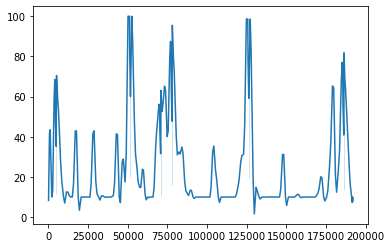

In [117]:
import seaborn as sns
g = sns.lineplot(x=graph['x'], y=graph['y'])

In [26]:
graph = await yt_handler.get_most_replayed('I-i4fat9_fQ', 100)

-    +    -    +     RequestsYTHandler:  Opening URL https://www.youtube.com/watch?v=I-i4fat9_fQ


In [28]:
def sliding_window(graph, window_size_in_ms):
    offset = None
    return offset

import pandas as pd
df_graph = pd.DataFrame(data = graph)
df_graph.rename(columns = {'x': 'time', 'y': 'popularity'}, inplace=True)

df_graph['time_shift'] = df_graph[['time']].diff().set_index(df_graph.index - 1)
df_graph.fillna(0, inplace=True)
df_graph['scaled_popularity'] = df_graph['time_shift'] * df_graph['popularity']
df_graph.loc[14:120, 'scaled_popularity'].cumsum()

window_size_in_sec = 15
window_dt = pd.offsets.Second(window_size_in_sec)

In [32]:
df_windowed_popularity

1970-01-01 00:00:00.000000000    0.418974
1970-01-01 00:00:01.010101010    0.499240
1970-01-01 00:00:02.020202020    1.092269
1970-01-01 00:00:03.030303030    1.370716
1970-01-01 00:00:04.040404040    1.470431
                                   ...   
1970-01-01 00:01:35.959595959    2.242015
1970-01-01 00:01:36.969696969    2.816695
1970-01-01 00:01:37.979797979    3.178352
1970-01-01 00:01:38.989898989    3.417678
1970-01-01 00:01:40.000000000    3.363574
Name: scaled_popularity, Length: 98, dtype: float64

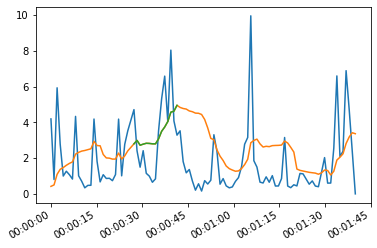

In [34]:
df_windowed_popularity = (
                df_graph 
                    .set_index(pd.to_datetime(df_graph['time'].array, unit='s'))['scaled_popularity']
                    .rolling(window=f'{window_size_in_sec}s')
                    .sum()
                     )
                    
snippet_end = df_windowed_popularity.idxmax()
snippet_start = snippet_end - window_dt

g = (df_graph.set_index(pd.to_datetime(df_graph['time'].array, unit='s'))['scaled_popularity'] * 10).plot()
g = df_windowed_popularity.plot()      # orange
g = df_windowed_popularity[snippet_start:snippet_end].plot() # green

In [35]:
(snippet_start.minute*60 + snippet_start.second) * 1000

26000

<AxesSubplot:>

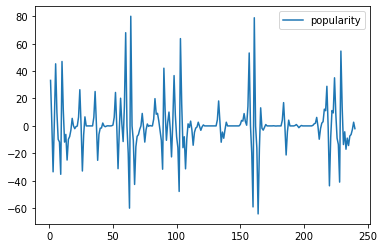

In [124]:

df_graph[['popularity']].diff().plot()

## async


In [3]:
import asyncio
asyncio.get_event_loop()

<_WindowsSelectorEventLoop running=True closed=False debug=False>

# Seleniumless

In [ ]:
# opening stuff in browsers
# https://stackoverflow.com/a/61494330/19347187

# ff cmd headless
# https://wiki.mozilla.org/Firefox/CommandLineOptions#-headless

In [3]:
videos = ['eRhg7qPLeN8', 'I-i4fat9_fQ', 'u4N45v8f7cY', 'NIJ5RiMAmNs', 'EWufOLC34jg']
url = "http://www.youtube.com/watch?v=" + videos[0]

## via urllib

In [34]:
from urllib.request import urlopen

response = None
with urlopen(url) as response:
    yt_string = response.read().decode()

['{"key":"HEATSEEKER","value":{"trackingParams":"CEsQxocGIhMIzPC51uCl-QIVqtURCB0dpQVj","heatmap":{"heatmapRenderer":{"maxHeightDp":40,"minHeightDp":4,"showHideAnimationDurationMillis":200,"heatMarkers":[{"heatMarkerRenderer":{"timeRangeStartMillis":0,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.6817207673611223}},{"heatMarkerRenderer":{"timeRangeStartMillis":4100,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.39760043790444299}},{"heatMarkerRenderer":{"timeRangeStartMillis":8200,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.49899952546069409}},{"heatMarkerRenderer":{"timeRangeStartMillis":12300,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.82590187641196866}},{"heatMarkerRenderer":{"timeRangeStartMillis":16400,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":1}},{"heatMarkerRenderer":{"timeRangeStartMillis":20500,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.88891032

In [84]:
response.__dict__.keys()#.json()

dict_keys(['fp', 'debuglevel', '_method', 'headers', 'msg', 'version', 'status', 'reason', 'chunked', 'chunk_left', 'length', 'will_close', 'code', 'url'])

In [100]:
response.status

200

## via requests

### requests

In [4]:
# prefer requests due to high-level as opposed to low-level urllib

from time import perf_counter as time_performance
time_counter = time_performance()

import requests
simple_response = requests.get(url)
yt_string = simple_response.text

print(f'This took {time_performance() - time_counter} seconds')
print(simple_response.url)

This took 1.2643944000000005 seconds
https://www.youtube.com/watch?v=eRhg7qPLeN8


In [10]:
# with proxy
from time import perf_counter as time_performance
time_counter = time_performance()

from src.ProxyServer import ProxyServer
from src.streamlit_interface import AsyncHandler

ash = AsyncHandler()
ps = ProxyServer(_async_handler = ash)

from asyncio import create_task as asyncio_create_task
await asyncio_create_task(ps.find_proxies())

# format "https://10.10.1.11:1080"
https_proxy = await ash.yielder(ps.get_random_proxy)
https_proxy = https_proxy.replace('https', 'http')
print(https_proxy)

proxy = {'https': https_proxy, 'http': https_proxy}

# using sessions
# s = requests.Session()
# s.proxies = proxies
# s.get

# user agent
# headers = {'user-agent': 'my-app/0.0.1'}
#r = requests.get(url, headers=headers)

# send cookies to the server
# cookies = dict(cookies_are='working')
# r = requests.get(url, cookies=cookies)

from requests.exceptions import ProxyError
import requests 

try:
    response = requests.get(url, proxies=proxy, timeout=10)
except ProxyError as pe:
    print(pe)

yt_string = response.text

print(f'This took {time_performance() - time_counter} seconds')
print(response.url)

C:\Users\circl\anaconda3\lib\site-packages\charset_normalizer\api.py:105: UserWarning: Trying to detect encoding from a tiny portion of (14) byte(s).
  warn('Trying to detect encoding from a tiny portion of ({}) byte(s).'.format(length))
2022-08-01 23:16:25.066 Done! Total found proxies: 529


http://178.254.24.12:3128

This took 23.248957099999984 seconds
https://www.youtube.com/watch?v=u4N45v8f7cY


### comparing differences with or without proxy

In [11]:
for k in response.__dict__.keys():
    if k != '_content':
        print(k, eval('response.' + k))

_content_consumed True
_next None
status_code 200
headers {'Content-Type': 'text/html; charset=utf-8', 'X-Content-Type-Options': 'nosniff', 'Cache-Control': 'no-cache, no-store, max-age=0, must-revalidate', 'Pragma': 'no-cache', 'Expires': 'Mon, 01 Jan 1990 00:00:00 GMT', 'Date': 'Mon, 01 Aug 2022 21:16:46 GMT', 'X-Frame-Options': 'SAMEORIGIN', 'Strict-Transport-Security': 'max-age=31536000', 'Permissions-Policy': 'ch-ua-arch=*, ch-ua-bitness=*, ch-ua-full-version=*, ch-ua-full-version-list=*, ch-ua-model=*, ch-ua-platform=*, ch-ua-platform-version=*', 'Report-To': '{"group":"youtube_main","max_age":2592000,"endpoints":[{"url":"https://csp.withgoogle.com/csp/report-to/youtube_main"}]}', 'Cross-Origin-Opener-Policy-Report-Only': 'same-origin-allow-popups; report-to="youtube_main"', 'P3P': 'CP="This is not a P3P policy! See http://support.google.com/accounts/answer/151657?hl=de for more info."', 'Content-Encoding': 'gzip', 'Server': 'ESF', 'X-XSS-Protection': '0', 'Set-Cookie': 'YSC=9DeH

2022-08-01 23:16:53.280 Done! Total found proxies: 535


In [40]:
for k in simple_response.__dict__.keys():
    if k != '_content':
        print(k, eval('response.' + k))

_content_consumed True
_next None
status_code 200
headers {'Content-Type': 'text/html; charset=utf-8', 'X-Content-Type-Options': 'nosniff', 'Cache-Control': 'no-cache, no-store, max-age=0, must-revalidate', 'Pragma': 'no-cache', 'Expires': 'Mon, 01 Jan 1990 00:00:00 GMT', 'Date': 'Mon, 01 Aug 2022 20:37:46 GMT', 'X-Frame-Options': 'SAMEORIGIN', 'Strict-Transport-Security': 'max-age=31536000', 'Report-To': '{"group":"youtube_main","max_age":2592000,"endpoints":[{"url":"https://csp.withgoogle.com/csp/report-to/youtube_main"}]}', 'Cross-Origin-Opener-Policy-Report-Only': 'same-origin-allow-popups; report-to="youtube_main"', 'Permissions-Policy': 'ch-ua-arch=*, ch-ua-bitness=*, ch-ua-full-version=*, ch-ua-full-version-list=*, ch-ua-model=*, ch-ua-platform=*, ch-ua-platform-version=*', 'P3P': 'CP="This is not a P3P policy! See http://support.google.com/accounts/answer/151657?hl=de for more info."', 'Content-Encoding': 'gzip', 'Server': 'ESF', 'X-XSS-Protection': '0', 'Set-Cookie': 'YSC=yZs1

2022-08-01 22:37:56.839 Done! Total found proxies: 550


In [12]:
######################################################    response object

shared = [k for k in response.headers.keys() if k in simple_response.headers.keys()]
only_proxy = [k for k in response.headers.keys() if k not in shared]
only_simple = [k for k in simple_response.headers.keys() if k not in shared]

empty = ''
for k in shared:
    if simple_response.headers[k] != response.headers[k]:
        print(f'SHARED: {k:<15} : {simple_response.headers[k]:<35} ----- {response.headers[k]}')
    else:
        print(f'SHARED: {k:<15} : ----- {simple_response.headers[k]}')
for k in only_proxy:
    print(f'PROXY: {k:<15} : {empty:<25} ----- {response.headers[k]}')
for k in only_simple:
    print(f'SIMPLE: {k:<15} : {simple_response.headers[k]:<25} ----- {empty}')
    

SHARED: Content-Type    : ----- text/html; charset=utf-8
SHARED: X-Content-Type-Options : ----- nosniff
SHARED: Cache-Control   : ----- no-cache, no-store, max-age=0, must-revalidate
SHARED: Pragma          : ----- no-cache
SHARED: Expires         : ----- Mon, 01 Jan 1990 00:00:00 GMT
SHARED: Date            : Mon, 01 Aug 2022 21:15:40 GMT       ----- Mon, 01 Aug 2022 21:16:46 GMT
SHARED: X-Frame-Options : ----- SAMEORIGIN
SHARED: Strict-Transport-Security : ----- max-age=31536000
SHARED: Permissions-Policy : ----- ch-ua-arch=*, ch-ua-bitness=*, ch-ua-full-version=*, ch-ua-full-version-list=*, ch-ua-model=*, ch-ua-platform=*, ch-ua-platform-version=*
SHARED: Report-To       : ----- {"group":"youtube_main","max_age":2592000,"endpoints":[{"url":"https://csp.withgoogle.com/csp/report-to/youtube_main"}]}
SHARED: Cross-Origin-Opener-Policy-Report-Only : ----- same-origin-allow-popups; report-to="youtube_main"
SHARED: P3P             : CP="This is not a P3P policy! See http://support.google.

In [51]:
######################################################    cookies

cookies = response.headers['Set-Cookie']
simple_cookies = simple_response.headers['Set-Cookie']

from re import findall as re_findall

pattern = r'([^=]*)=([^;]*);'
matches = re_findall(pattern, cookies)
(keys, values) = list(zip(*matches))

matches = re_findall(pattern, simple_cookies)
(simple_keys, simple_values) = list(zip(*matches))

shared = [k for k in keys if k in simple_keys]
only_proxy = [k for k in keys if k not in shared]
only_simple = [k for k in simple_keys if k not in shared]

empty = ''
for k in shared:
    if simple_values[simple_keys.index(k)] != values[keys.index(k)]:
        print(f'SHARED: {k:<15} : {simple_values[simple_keys.index(k)]:<35} ----- {values[keys.index(k)]}')
    else:
        print(f'SHARED: {k:<15} : ----- {simple_values[simple_keys.index(k)]}')
for k in only_proxy:
    print(f'PROXY: {k:<15} : {empty:<25} ----- {values[keys.index(k)]}')
for k in only_simple:
    print(f'SIMPLE: {k:<15} : {simple_values[simple_keys.index(k)]:<25} ----- {empty}')
    

SHARED: YSC             : x68YBgvN49E                         ----- yZs1xiIjVnU
SHARED:  Domain         : ----- .youtube.com
SHARED:  Path           : ----- /
SHARED:  Secure; HttpOnly; SameSite : ----- none, VISITOR_INFO1_LIVE=
SHARED:  Domain         : ----- .youtube.com
SHARED:  Expires        : Tue, 05-Nov-2019 20:37:36 GMT       ----- Tue, 05-Nov-2019 20:37:46 GMT
SHARED:  Path           : ----- /
SHARED:  Secure; HttpOnly; SameSite : ----- none, VISITOR_INFO1_LIVE=
SHARED:  Domain         : ----- .youtube.com
SHARED:  Expires        : Tue, 05-Nov-2019 20:37:36 GMT       ----- Tue, 05-Nov-2019 20:37:46 GMT
SHARED:  Path           : ----- /
SHARED:  Secure; HttpOnly; SameSite : ----- none, VISITOR_INFO1_LIVE=
SHARED:  expires        : Wed, 31-Jul-2024 20:37:36 GMT       ----- Wed, 31-Jul-2024 20:37:46 GMT
SHARED:  path           : ----- /
SHARED:  domain         : ----- .youtube.com


In [20]:
######################################################    request object

request = response.request.__dict__
simple_request = simple_response.request.__dict__

shared = [k for k in request.keys() if k in simple_request.keys()]
only_proxy = [k for k in request.keys() if k not in shared]
only_simple = [k for k in simple_request.keys() if k not in shared]

empty = ''
for k in shared:
    if simple_request[k] != request[k]:
        print(f'SHARED: {k:<15} : {simple_request[k]:<35} ----- {request[k]}')
    else:
        print(f'SHARED: {k:<15} : ----- {simple_request[k]}')
for k in only_proxy:
    print(f'PROXY: {k:<15} : {empty:<25} ----- {request[k]}')
for k in only_simple:
    print(f'SIMPLE: {k:<15} : {simple_request[k]:<25} ----- {empty}')
    

SHARED: method          : ----- GET
SHARED: url             : ----- https://www.youtube.com/watch?v=u4N45v8f7cY
SHARED: headers         : ----- {'User-Agent': 'python-requests/2.27.1', 'Accept-Encoding': 'gzip, deflate, br', 'Accept': '*/*', 'Connection': 'keep-alive'}
SHARED: _cookies        : ----- <RequestsCookieJar[]>
SHARED: body            : ----- None
SHARED: hooks           : ----- {'response': []}
SHARED: _body_position  : ----- None


.


.



if both requests (with or without proxies) are successful, there are no differences in request, response or cookies

### extracting heatmap

In [ ]:

# response part snippet 
{
    "key":"HEATSEEKER",
    "value":
    {
        "trackingParams":"CEgQxocGIhMI7Y6g55Cl-QIVTssRCB2vkwS-",
        "heatmap":
        {
            "heatmapRenderer":
            {
                "maxHeightDp":40,
                "minHeightDp":4,
                "showHideAnimationDurationMillis":200,
                "heatMarkers":
                [
                    {
                        "heatMarkerRenderer":
                        {
                            "timeRangeStartMillis":0,
                            "markerDurationMillis":4100,
                            "heatMarkerIntensityScoreNormalized":0.6817207673611223
                        }
                    },
                    {
                        "heatMarkerRenderer":
                        {
                            "timeRangeStartMillis":4100,
                            "markerDurationMillis":4100,
                            "heatMarkerIntensityScoreNormalized":0.39760043790444299}},
                    {"heatMarkerRenderer":{"timeRangeStartMillis":8200,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.49899952546069409}},
                    {"heatMarkerRenderer":{"timeRangeStartMillis":12300,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.82590187641196866}},{"heatMarkerRenderer":{"timeRangeStartMillis":16400,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":1}},{"heatMarkerRenderer":{"timeRangeStartMillis":20500,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.88891032706791484}},{"heatMarkerRenderer":{"timeRangeStartMillis":24600,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.34418492250441063}},{"heatMarkerRenderer":{"timeRangeStartMillis":28700,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.21182322714579069}},{"heatMarkerRenderer":{"timeRangeStartMillis":32800,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.17604726968507944}},{"heatMarkerRenderer":{"timeRangeStartMillis":36900,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.18038567298350253}},{"heatMarkerRenderer":{"timeRangeStartMillis":41000,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.17930931500304756}},{"heatMarkerRenderer":{"timeRangeStartMillis":45100,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.16394296101814926}},{"heatMarkerRenderer":{"timeRangeStartMillis":49200,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.14869906602523522}},{"heatMarkerRenderer":{"timeRangeStartMillis":53300,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.16831373582407552}},{"heatMarkerRenderer":{"timeRangeStartMillis":57400,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.16405423673619793}},{"heatMarkerRenderer":{"timeRangeStartMillis":61500,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.16030586896930704}},{"heatMarkerRenderer":{"timeRangeStartMillis":65600,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.16395800059344193}},{"heatMarkerRenderer":{"timeRangeStartMillis":69700,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.16001510384698195}},{"heatMarkerRenderer":{"timeRangeStartMillis":73800,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.14439534801512954}},{"heatMarkerRenderer":{"timeRangeStartMillis":77900,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.12229297821082613}},{"heatMarkerRenderer":{"timeRangeStartMillis":82000,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.12671302797853753}},{"heatMarkerRenderer":{"timeRangeStartMillis":86100,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.11733643122875687}},{"heatMarkerRenderer":{"timeRangeStartMillis":90200,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.12344046352742312}},{"heatMarkerRenderer":{"timeRangeStartMillis":94300,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.12892682346816461}},{"heatMarkerRenderer":{"timeRangeStartMillis":98400,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.12999180535961616}},{"heatMarkerRenderer":{"timeRangeStartMillis":102500,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.12342542395213045}},{"heatMarkerRenderer":{"timeRangeStartMillis":106600,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.11274895371045818}},{"heatMarkerRenderer":{"timeRangeStartMillis":110700,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.093196113276709971}},{"heatMarkerRenderer":{"timeRangeStartMillis":114800,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.11300576195694439}},{"heatMarkerRenderer":{"timeRangeStartMillis":118900,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.15504964452399853}},{"heatMarkerRenderer":{"timeRangeStartMillis":123000,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.16515848862980256}},{"heatMarkerRenderer":{"timeRangeStartMillis":127100,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.12764807393815136}},{"heatMarkerRenderer":{"timeRangeStartMillis":131200,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.082920259186298986}},{"heatMarkerRenderer":{"timeRangeStartMillis":135300,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.086575004525798124}},{"heatMarkerRenderer":{"timeRangeStartMillis":139400,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.07671430270037502}},{"heatMarkerRenderer":{"timeRangeStartMillis":143500,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.080081571485650815}},{"heatMarkerRenderer":{"timeRangeStartMillis":147600,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.075253557170203211}},{"heatMarkerRenderer":{"timeRangeStartMillis":151700,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.078400898946694136}},{"heatMarkerRenderer":{"timeRangeStartMillis":155800,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.083143560458771318}},{"heatMarkerRenderer":{"timeRangeStartMillis":159900,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.08766499881632972}},{"heatMarkerRenderer":{"timeRangeStartMillis":164000,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.076789136370599129}},{"heatMarkerRenderer":{"timeRangeStartMillis":168100,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.06104192977889468}},{"heatMarkerRenderer":{"timeRangeStartMillis":172200,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.056519570193789857}},{"heatMarkerRenderer":{"timeRangeStartMillis":176300,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.062066484777785993}},{"heatMarkerRenderer":{"timeRangeStartMillis":180400,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.063748153527926579}},{"heatMarkerRenderer":{"timeRangeStartMillis":184500,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.066596096351831793}},{"heatMarkerRenderer":{"timeRangeStartMillis":188600,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.08934050819624717}},{"heatMarkerRenderer":{"timeRangeStartMillis":192700,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.10846980890955581}},{"heatMarkerRenderer":{"timeRangeStartMillis":196800,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.11134836648145709}},{"heatMarkerRenderer":{"timeRangeStartMillis":200900,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.10107580095914784}},{"heatMarkerRenderer":{"timeRangeStartMillis":205000,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.12363580661505651}},{"heatMarkerRenderer":{"timeRangeStartMillis":209100,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.14027821071901811}},{"heatMarkerRenderer":{"timeRangeStartMillis":213200,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.11750619418405484}},{"heatMarkerRenderer":{"timeRangeStartMillis":217300,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.078742395855761468}},{"heatMarkerRenderer":{"timeRangeStartMillis":221400,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.055132383612004669}},{"heatMarkerRenderer":{"timeRangeStartMillis":225500,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.04812942604310274}},{"heatMarkerRenderer":{"timeRangeStartMillis":229600,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.045296758457350914}},{"heatMarkerRenderer":{"timeRangeStartMillis":233700,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.047245208277765099}},{"heatMarkerRenderer":{"timeRangeStartMillis":237800,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.038526539387297984}},{"heatMarkerRenderer":{"timeRangeStartMillis":241900,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.042261688610092586}},{"heatMarkerRenderer":{"timeRangeStartMillis":246000,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.044869844473223876}},{"heatMarkerRenderer":{"timeRangeStartMillis":250100,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.05658897290626938}},{"heatMarkerRenderer":{"timeRangeStartMillis":254200,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.044569031543473907}},{"heatMarkerRenderer":{"timeRangeStartMillis":258300,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.037266760717571984}},{"heatMarkerRenderer":{"timeRangeStartMillis":262400,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.044346480107376567}},{"heatMarkerRenderer":{"timeRangeStartMillis":266500,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.031777819197310875}},{"heatMarkerRenderer":{"timeRangeStartMillis":270600,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.028839531802167456}},{"heatMarkerRenderer":{"timeRangeStartMillis":274700,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.022221047478568071}},{"heatMarkerRenderer":{"timeRangeStartMillis":278800,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.027685501485211619}},{"heatMarkerRenderer":{"timeRangeStartMillis":282900,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.021204162234598093}},{"heatMarkerRenderer":{"timeRangeStartMillis":287000,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.029978501119934185}},{"heatMarkerRenderer":{"timeRangeStartMillis":291100,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.037001104401860878}},{"heatMarkerRenderer":{"timeRangeStartMillis":295200,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.078214564607508863}},
                    {"heatMarkerRenderer":{"timeRangeStartMillis":299300,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.074861864071804327}},{"heatMarkerRenderer":{"timeRangeStartMillis":303400,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.066591907980080065}},{"heatMarkerRenderer":{"timeRangeStartMillis":307500,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.064012792208557351}},{"heatMarkerRenderer":{"timeRangeStartMillis":311600,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.073123389860284063}},{"heatMarkerRenderer":{"timeRangeStartMillis":315700,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.05396227466077938}},{"heatMarkerRenderer":{"timeRangeStartMillis":319800,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.064950537579121129}},{"heatMarkerRenderer":{"timeRangeStartMillis":323900,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.080977379578956163}},{"heatMarkerRenderer":{"timeRangeStartMillis":328000,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.094025303764071477}},{"heatMarkerRenderer":{"timeRangeStartMillis":332100,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.10186743535607051}},{"heatMarkerRenderer":{"timeRangeStartMillis":336200,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.10187662620763827}},{"heatMarkerRenderer":{"timeRangeStartMillis":340300,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.099148078758528047}},{"heatMarkerRenderer":{"timeRangeStartMillis":344400,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.11227270049285673}},{"heatMarkerRenderer":{"timeRangeStartMillis":348500,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.14084504417071847}},{"heatMarkerRenderer":{"timeRangeStartMillis":352600,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.14787152517789867}},{"heatMarkerRenderer":{"timeRangeStartMillis":356700,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.16953005611989669}},{"heatMarkerRenderer":{"timeRangeStartMillis":360800,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.19972663108157471}},{"heatMarkerRenderer":{"timeRangeStartMillis":364900,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.24608089449052367}},{"heatMarkerRenderer":{"timeRangeStartMillis":369000,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.2778182760833261}},{"heatMarkerRenderer":{"timeRangeStartMillis":373100,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.28701439792959466}},{"heatMarkerRenderer":{"timeRangeStartMillis":377200,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.22549578645516996}},{"heatMarkerRenderer":{"timeRangeStartMillis":381300,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.12503005237071482}},{"heatMarkerRenderer":{"timeRangeStartMillis":385400,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.10754348247578832}},{"heatMarkerRenderer":{"timeRangeStartMillis":389500,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.070742980728133967}},{"heatMarkerRenderer":{"timeRangeStartMillis":393600,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.04324134983401836}},{"heatMarkerRenderer":{"timeRangeStartMillis":397700,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.022069623378612738}},{"heatMarkerRenderer":{"timeRangeStartMillis":401800,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0.0064962395705794197}},
                    {"heatMarkerRenderer":{"timeRangeStartMillis":405900,"markerDurationMillis":4100,"heatMarkerIntensityScoreNormalized":0}
                    }
                ],
                "heatMarkersDecorations":
                [
                    {
                        "timedMarkerDecorationRenderer":
                        {
                            "visibleTimeRangeStartMillis":12300,
                            "visibleTimeRangeEndMillis":24600,
                            "decorationTimeMillis":16400,
                            "label":
                            {
                                "runs":
                                [
                                    {
                                        "text":"Nejčastěji přehráváno opakovaně"
                                    }
                                ]
                            },
                            "icon":"AUTO_AWESOME",
                            "trackingParams":"CEkQ38YIGGQiEwjtjqDnkKX5AhVOyxEIHa-TBL4="
                        }
                    }
                ]
            }
        }
    }
}

In [5]:
pattern = r'{"heatMarkerRenderer":{"timeRangeStartMillis":(\d+),"markerDurationMillis":(\d+),"heatMarkerIntensityScoreNormalized":(\d+.\d+)}}'

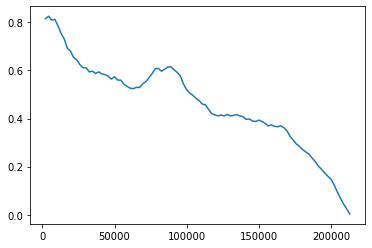

In [6]:
from re import findall as re_findall
matches = re_findall(pattern, yt_string)
a, b, c = list(zip(*[(float(a), float(b), float(c)) for a,b,c in matches]))

import matplotlib.pyplot as plt
plt.plot(a,c)
plt.show()

In [7]:
times = list(map(lambda x: x / a[-1] * 190, a))
graph = {'x' : times, 'y' : c}

from pandas import to_datetime as pd_to_datetime
pd_to_datetime(times, unit='s')

DatetimeIndex(['1970-01-01 00:00:01.938775510',
               '1970-01-01 00:00:03.877551020',
               '1970-01-01 00:00:05.816326531',
               '1970-01-01 00:00:07.755102041',
               '1970-01-01 00:00:09.693877551',
               '1970-01-01 00:00:11.632653061',
               '1970-01-01 00:00:13.571428571',
               '1970-01-01 00:00:15.510204082',
               '1970-01-01 00:00:17.448979592',
               '1970-01-01 00:00:19.387755102',
               '1970-01-01 00:00:21.326530612',
               '1970-01-01 00:00:23.265306121',
               '1970-01-01 00:00:25.204081633',
               '1970-01-01 00:00:27.142857143',
               '1970-01-01 00:00:29.081632653',
               '1970-01-01 00:00:31.020408163',
               '1970-01-01 00:00:32.959183673',
               '1970-01-01 00:00:34.897959184',
               '1970-01-01 00:00:36.836734694',
               '1970-01-01 00:00:38.775510204',
               '1970-01-01 00:00:40.7142

In [9]:
from pandas import DataFrame 
df_graph = DataFrame(data = {'time' :times, 'popularity' : c})

df_windowed_popularity = (
        df_graph 
            .set_index(pd_to_datetime(df_graph['time'].array, unit='s'))['popularity']
            .rolling(window=f'15s')
            .sum()
         )

In [10]:
from pandas import offsets as pd_offsets
window_dt = pd_offsets.Second(15)
snippet = df_windowed_popularity.idxmax()#.minute

(snippet - window_dt).minute

0

In [11]:
from numpy import std as np_std
if np_std(b) == 0:
    print('is_regular True')
else:
    print('is_regular False')
graph['is_regular'] = True

is_regular True


In [12]:
mg.sliding_window(graph, 15)

-+-+ MedleyGenerator:  Choosing best moment from popularity graph.
-+-+ MedleyGenerator:  Found highest popularity at 0:0


0

In [20]:
graph2 = await mg.yt_handler.get_most_replayed(videos[0], 190)
#
mg.sliding_window(graph2, 15)

-    +    -    +     RequestsYTHandler:  Opening URL https://www.youtube.com/watch?v=eRhg7qPLeN8
-+-+ MedleyGenerator:  Choosing best moment from popularity graph.
-+-+ MedleyGenerator:  Found highest popularity at 0:0


0

In [31]:
graph2['x']

[1.9191919191919193,
 3.8383838383838387,
 5.757575757575758,
 7.676767676767677,
 9.595959595959595,
 11.515151515151516,
 13.434343434343434,
 15.353535353535355,
 17.272727272727273,
 19.19191919191919,
 21.11111111111111,
 23.03030303030303,
 24.94949494949495,
 26.86868686868687,
 28.78787878787879,
 30.70707070707071,
 32.62626262626262,
 34.54545454545455,
 36.464646464646464,
 38.38383838383838,
 40.303030303030305,
 42.22222222222222,
 44.14141414141414,
 46.06060606060606,
 47.979797979797986,
 49.8989898989899,
 51.81818181818181,
 53.73737373737374,
 55.656565656565654,
 57.57575757575758,
 59.494949494949495,
 61.41414141414142,
 63.33333333333333,
 65.25252525252525,
 67.17171717171718,
 69.0909090909091,
 71.01010101010101,
 72.92929292929293,
 74.84848484848484,
 76.76767676767676,
 78.68686868686869,
 80.60606060606061,
 82.52525252525253,
 84.44444444444444,
 86.36363636363636,
 88.28282828282828,
 90.20202020202021,
 92.12121212121212,
 94.04040404040404,
 95.9595959

### error prone with json

In [67]:
pattern = r'"heatMarkers":\[([^\]]*)\]'

In [63]:
from re import search as re_search
from re import findall as re_findall

# cannot use json directly on full response; regex search first
yt_string = mg.yt_handler.response.text
#match = re_findall(pattern, yt_string)
match = re_search(pattern, yt_string).group(1)

import json
heatmap_json = None
heatmap_json = json.loads(match)

heatmap_json

AttributeError: 'NoneType' object has no attribute 'group'

100 0.1404374622537725


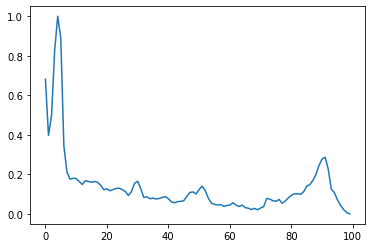

In [15]:
import matplotlib.pyplot as plt

Y = []
for heatMarker in heatmap_json['value']['heatmap']['heatmapRenderer']['heatMarkers']:
    heatMarker = heatMarker['heatMarkerRenderer']
    intensityScoreNormalized = heatMarker['heatMarkerIntensityScoreNormalized']
    Y += [intensityScoreNormalized]

from statistics import mean
print(len(Y), mean(Y))
plt.plot(Y)
plt.show()

### comparing to selenium results

In [2]:
##
## compare to current yt handler
##

from asyncio import create_task as asyncio_create_task
from src.streamlit_interface import YoutubeHandler, AsyncHandler

ash = AsyncHandler()
yt = YoutubeHandler(_async_handler = ash)
await asyncio_create_task(yt.setup())

2022-08-01 14:42:39.967 INFO    numexpr.utils: NumExpr defaulting to 4 threads.
2022-08-01 14:42:42.913 
  command:

    streamlit run C:\Users\circl\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


-+-+ This is AsyncHandler registring.
- + - +  This is YoutubeHandler registring.
- + - +  YoutubeHandler:  Starting Proxy Server
-  +  -  +   This is ProxyServer registring.
- + - +  YoutubeHandler:  Starting Proxy Server SUCCESSFUL
- + - +  YoutubeHandler:  Initialising Selenium Webdriver
- + - +  YoutubeHandler:  Initialising Selenium Webdriver SUCCESSFUL
- + - +  YoutubeHandler:  Initialising Selenium WaitWebdriver
- + - +  YoutubeHandler:  Initialising Selenium WaitWebdriver SUCCESSFUL
- + - +  YoutubeHandler:  Using proxy = https://178.254.24.12:3128.
- + - +  YoutubeHandler:  Setting new user agent failed.


In [ ]:
await yt.get_most_replayed(videoId, 100)

# is constantly blocked by google

- + - +  YoutubeHandler:  Opening URL
- + - +  YoutubeHandler:  Reloading: 0. try.


2022-08-01 12:34:34.666 1.09.74.59:476: Error at creating: 


- + - +  YoutubeHandler:  Using proxy = https://188.130.64.51:8080.
- + - +  YoutubeHandler:  Reloading: 1. try.
- + - +  YoutubeHandler:  Using proxy = https://173.212.229.53:3128.
- + - +  YoutubeHandler:  Attempting to scrape heat map.
- + - +  YoutubeHandler:  Ran into captcha police. New proxy, user agent and reloading.
- + - +  YoutubeHandler:  Using proxy = https://188.72.108.3:8090.
- + - +  YoutubeHandler:  Setting new user agent failed.
- + - +  YoutubeHandler:  Ran into captcha police. New proxy, user agent and reloading.


In [16]:
# snippet taken from manually downloaded site 
html = '''<div class="ytp-heat-map-chapter" style="width: 148px; left: 0px;">
<svg class="ytp-heat-map-svg" height="100%" preserveAspectRatio="none" version="1.1" viewBox="0 0 1000 100" width="100%" style="height: 40px;"><defs>
<clipPath id="4">
<path class="ytp-heat-map-path" d="M 0.0,100.0 C 4.0,86.4 8.0,39.8 20.0,31.8 C 32.0,23.9 44.0,56.6 60.0,60.2 C 76.0,63.9 84.0,58.7 100.0,50.1 C 116.0,41.5 124.0,27.4 140.0,17.4 C 156.0,7.4 164.0,1.3 180.0,0.0 C 196.0,-1.3 204.0,-2.0 220.0,11.1 C 236.0,24.2 244.0,52.0 260.0,65.6 C 276.0,79.1 284.0,75.5 300.0,78.8 C 316.0,82.2 324.0,81.8 340.0,82.4 C 356.0,83.0 364.0,82.0 380.0,82.0 C 396.0,81.9 404.0,81.7 420.0,82.1 C 436.0,82.4 444.0,83.0 460.0,83.6 C 476.0,84.2 484.0,85.2 500.0,85.1 C 516.0,85.0 524.0,83.5 540.0,83.2 C 556.0,82.9 564.0,83.4 580.0,83.6 C 596.0,83.8 604.0,84.0 620.0,84.0 C 636.0,84.0 644.0,83.6 660.0,83.6 C 676.0,83.6 684.0,83.6 700.0,84.0 C 716.0,84.4 724.0,84.8 740.0,85.6 C 756.0,86.3 764.0,87.4 780.0,87.8 C 796.0,88.1 804.0,87.2 820.0,87.3 C 836.0,87.4 844.0,88.2 860.0,88.3 C 876.0,88.3 884.0,87.9 900.0,87.7 C 916.0,87.4 924.0,87.2 940.0,87.1 C 956.0,87.0 968.0,87.0 980.0,87.0 C 992.0,87.0 996.0,84.4 1000.0,87.0 C 1004.0,89.6 1000.0,97.4 1000.0,100.0" fill="white" fill-opacity="0.6"></path></clipPath></defs><rect class="ytp-heat-map-graph" clip-path="url(#4)" fill="white" fill-opacity="0.2" height="100%" width="100%" x="0" y="0"></rect><rect class="ytp-heat-map-hover" clip-path="url(#4)" height="100%" x="0" y="0"></rect><rect class="ytp-heat-map-play" clip-path="url(#4)" height="100%" x="0" y="0"></rect></svg></div><div class="ytp-heat-map-chapter" style="width: 82px; left: 150px;"><svg class="ytp-heat-map-svg" height="100%" preserveAspectRatio="none" version="1.1" viewBox="0 0 1000 100" width="100%" style="height: 40px;"><defs><clipPath id="5"><path class="ytp-heat-map-path" d="M 0.0,100.0 C 0.0,97.4 -7.1,89.6 0.0,87.0 C 7.1,84.4 14.3,86.9 35.7,87.0 C 57.1,87.1 78.6,87.3 107.1,87.7 C 135.7,88.0 150.0,88.3 178.6,88.7 C 207.1,89.2 221.4,90.0 250.0,90.0 C 278.6,90.0 292.9,89.8 321.4,88.7 C 350.0,87.6 364.3,85.5 392.9,84.5 C 421.4,83.5 435.7,82.9 464.3,83.5 C 492.9,84.0 507.1,85.9 535.7,87.2 C 564.3,88.5 578.6,89.4 607.1,90.0 C 635.7,90.6 650.0,90.0 678.6,90.0 C 707.1,90.0 721.4,90.0 750.0,90.0 C 778.6,90.0 792.9,90.0 821.4,90.0 C 850.0,90.0 864.3,90.0 892.9,90.0 C 921.4,90.0 942.9,90.0 964.3,90.0 C 985.7,90.0 992.9,88.0 1000.0,90.0 C 1007.1,92.0 1000.0,98.0 1000.0,100.0" fill="white" fill-opacity="0.6"></path></clipPath></defs><rect class="ytp-heat-map-graph" clip-path="url(#5)" fill="white" fill-opacity="0.2" height="100%" width="100%" x="0" y="0"></rect><rect class="ytp-heat-map-hover" clip-path="url(#5)" height="100%" x="0" y="0"></rect><rect class="ytp-heat-map-play" clip-path="url(#5)" height="100%" x="0" y="0"></rect></svg></div><div class="ytp-heat-map-chapter" style="width: 46px; left: 234px;"><svg class="ytp-heat-map-svg" height="100%" preserveAspectRatio="none" version="1.1" viewBox="0 0 1000 100" width="100%" style="height: 40px;"><defs><clipPath id="6"><path class="ytp-heat-map-path" d="M 0.0,100.0 C 0.0,98.0 -11.1,92.0 0.0,90.0 C 11.1,88.0 22.2,90.0 55.6,90.0 C 88.9,90.0 122.2,90.0 166.7,90.0 C 211.1,90.0 233.3,90.0 277.8,90.0 C 322.2,90.0 344.4,90.0 388.9,90.0 C 433.3,90.0 455.6,90.0 500.0,90.0 C 544.4,90.0 566.7,90.0 611.1,90.0 C 655.6,90.0 677.8,90.0 722.2,90.0 C 766.7,90.0 788.9,90.0 833.3,90.0 C 877.8,90.0 911.1,90.0 944.4,90.0 C 977.8,90.0 988.9,88.0 1000.0,90.0 C 1011.1,92.0 1000.0,98.0 1000.0,100.0" fill="white" fill-opacity="0.6"></path></clipPath></defs><rect class="ytp-heat-map-graph" clip-path="url(#6)" fill="white" fill-opacity="0.2" height="100%" width="100%" x="0" y="0"></rect><rect class="ytp-heat-map-hover" clip-path="url(#6)" height="100%" x="0" y="0"></rect><rect class="ytp-heat-map-play" clip-path="url(#6)" height="100%" x="0" y="0"></rect></svg></div><div class="ytp-heat-map-chapter" style="width: 119px; left: 282px;"><svg class="ytp-heat-map-svg" height="100%" preserveAspectRatio="none" version="1.1" viewBox="0 0 1000 100" width="100%" style="height: 40px;"><defs><clipPath id="7"><path class="ytp-heat-map-path" d="M 0.0,100.0 C 0.0,98.0 -5.0,92.0 0.0,90.0 C 5.0,88.0 10.0,90.0 25.0,90.0 C 40.0,90.0 55.0,90.2 75.0,90.0 C 95.0,89.8 105.0,89.4 125.0,89.2 C 145.0,88.9 155.0,88.7 175.0,88.9 C 195.0,89.0 205.0,90.1 225.0,89.9 C 245.0,89.6 255.0,88.4 275.0,87.6 C 295.0,86.9 305.0,85.8 325.0,86.0 C 345.0,86.1 355.0,87.4 375.0,88.2 C 395.0,89.1 405.0,89.6 425.0,90.0 C 445.0,90.4 455.0,90.0 475.0,90.0 C 495.0,90.0 505.0,90.0 525.0,90.0 C 545.0,90.0 555.0,90.0 575.0,90.0 C 595.0,90.0 605.0,90.0 625.0,90.0 C 645.0,90.0 655.0,90.0 675.0,90.0 C 695.0,90.0 705.0,90.0 725.0,90.0 C 745.0,90.0 755.0,90.0 775.0,90.0 C 795.0,90.0 805.0,90.0 825.0,90.0 C 845.0,90.0 855.0,90.0 875.0,90.0 C 895.0,90.0 905.0,90.0 925.0,90.0 C 945.0,90.0 960.0,90.0 975.0,90.0 C 990.0,90.0 995.0,88.0 1000.0,90.0 C 1005.0,92.0 1000.0,98.0 1000.0,100.0" fill="white" fill-opacity="0.6"></path></clipPath></defs><rect class="ytp-heat-map-graph" clip-path="url(#7)" fill="white" fill-opacity="0.2" height="100%" width="100%" x="0" y="0"></rect><rect class="ytp-heat-map-hover" clip-path="url(#7)" height="100%" x="0" y="0"></rect><rect class="ytp-heat-map-play" clip-path="url(#7)" height="100%" x="0" y="0"></rect></svg></div><div class="ytp-heat-map-chapter" style="width: 213px; left: 403px;"><svg class="ytp-heat-map-svg" height="100%" preserveAspectRatio="none" version="1.1" viewBox="0 0 1000 100" width="100%" style="height: 40px;"><defs><clipPath id="8"><path class="ytp-heat-map-path" d="M 0.0,100.0 C 0.0,98.0 -2.8,92.0 0.0,90.0 C 2.8,88.0 5.6,90.0 13.9,90.0 C 22.2,90.0 30.6,90.0 41.7,90.0 C 52.8,90.0 58.3,90.0 69.4,90.0 C 80.6,90.0 86.1,90.0 97.2,90.0 C 108.3,90.0 113.9,90.0 125.0,90.0 C 136.1,90.0 141.7,90.0 152.8,90.0 C 163.9,90.0 169.4,90.0 180.6,90.0 C 191.7,90.0 197.2,90.0 208.3,90.0 C 219.4,90.0 225.0,90.0 236.1,90.0 C 247.2,90.0 252.8,90.0 263.9,90.0 C 275.0,90.0 280.6,90.0 291.7,90.0 C 302.8,90.0 308.3,90.0 319.4,90.0 C 330.6,90.0 336.1,90.0 347.2,90.0 C 358.3,90.0 363.9,90.0 375.0,90.0 C 386.1,90.0 391.7,90.0 402.8,90.0 C 413.9,90.0 419.4,90.0 430.6,90.0 C 441.7,90.0 447.2,90.0 458.3,90.0 C 469.4,90.0 475.0,89.9 486.1,89.8 C 497.2,89.8 502.8,89.8 513.9,89.8 C 525.0,89.8 530.6,90.2 541.7,90.0 C 552.8,89.8 558.3,89.6 569.4,88.8 C 580.6,88.0 586.1,86.6 597.2,85.9 C 608.3,85.2 613.9,85.8 625.0,85.2 C 636.1,84.6 641.7,84.1 652.8,83.0 C 663.9,82.0 669.4,81.6 680.6,80.0 C 691.7,78.5 697.2,77.0 708.3,75.4 C 719.4,73.8 725.0,73.0 736.1,72.2 C 747.2,71.4 752.8,70.3 763.9,71.3 C 775.0,72.3 780.6,74.2 791.7,77.5 C 802.8,80.7 808.3,85.1 819.4,87.5 C 830.6,89.9 836.1,88.7 847.2,89.2 C 858.3,89.7 863.9,89.8 875.0,90.0 C 886.1,90.2 891.7,90.0 902.8,90.0 C 913.9,90.0 919.4,90.0 930.6,90.0 C 941.7,90.0 947.2,90.0 958.3,90.0 C 969.4,90.0 977.8,90.0 986.1,90.0 C 994.4,90.0 997.2,88.0 1000.0,90.0 C 1002.8,92.0 1000.0,98.0 1000.0,100.0" fill="white" fill-opacity="0.6"></path></clipPath></defs><rect class="ytp-heat-map-graph" clip-path="url(#8)" fill="white" fill-opacity="0.2" height="100%" width="100%" x="0" y="0"></rect>'''

from re import findall as re_findall

chapter_times = re_findall("(width: \d+px; left: \d+px;)", html)
heatmaps = re_findall('ytp-heat-map-path" d="([CM.,\s\d-]*)"', html)

#chapter_times, heatmaps

graph = yt.build_graph(chapter_times, heatmaps, 100)
graph

- + - +  YoutubeHandler:  Assembling popularity graph. Last tuple for chapter: 1004.0,89.6
- + - +  YoutubeHandler:  Assembling popularity graph. Last tuple for chapter: 1007.1,92.0
- + - +  YoutubeHandler:  Assembling popularity graph. Last tuple for chapter: 1011.1,92.0
- + - +  YoutubeHandler:  Assembling popularity graph. Last tuple for chapter: 1005.0,92.0
- + - +  YoutubeHandler:  Assembling popularity graph. Last tuple for chapter: 1002.8,92.0


{'x': [0.09601094005738599,
  0.48005470028693,
  0.7680875204590879,
  1.4401641008607902,
  1.8242078610903338,
  2.4002735014346497,
  2.784317261664194,
  3.3603829020085096,
  3.744426662238054,
  4.32049230258237,
  5.28060170315623,
  5.6646454633857735,
  6.240711103730089,
  6.624754863959633,
  7.20082050430395,
  7.584864264533494,
  8.16092990487781,
  8.544973665107355,
  9.121039305451669,
  9.505083065681212,
  10.08114870602553,
  10.465192466255074,
  11.04125810659939,
  11.425301866828931,
  12.00136750717325,
  12.385411267402793,
  12.961476907747109,
  13.345520667976652,
  13.92158630832097,
  14.305630068550512,
  14.88169570889483,
  15.265739469124371,
  15.84180510946869,
  16.225848869698233,
  16.80191451004255,
  17.185958270272096,
  17.76202391061641,
  18.146067670845955,
  18.72213331119027,
  19.106177071419815,
  19.68224271176413,
  20.06628647199367,
  20.64235211233799,
  21.02639587256753,
  21.602461512911844,
  21.986505273141393,
  22.56257091

230 49.91862029232962


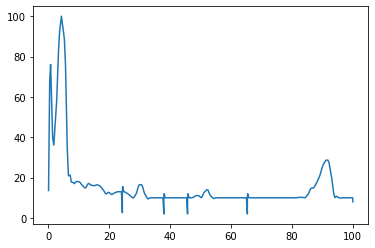

In [19]:
import matplotlib.pyplot as plt

from statistics import mean
print(len(graph['x']), mean(graph['x']))
plt.plot(graph['x'], graph['y'])
plt.show()

COMPARISON
heatgraph via request has only 100 values but looks like the smoothed actual graph
possibly good enough

## via webbrowser

In [27]:

link = "https://youtube.com/watch?v=u4N45v8f7cY"
import webbrowser

ff = webbrowser.get()
new_window = 1
ff.open_new(url = link)
print(ff)
ff.__dict__

{'name': '', 'basename': ''}

# Tests

### Full Test

In [1]:
from streamlit import experimental_singleton as st_singleton
st_singleton.clear()
from src.streamlit_interface import SpotifyHandler
SpotifyHandler.clear()

from asyncio import create_task as asyncio_create_task
from src.streamlit_interface import MedleyGenerator
    
mg = MedleyGenerator(player_name = 'Web Player (Firefox)')
await asyncio_create_task(mg.setup())

2022-08-12 09:39:14.689 INFO    numexpr.utils: NumExpr defaulting to 4 threads.
2022-08-12 09:39:20.569 
  command:

    streamlit run C:\Users\circl\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


-+-+ This is MedleyGenerator registring.
- + - +  This is MedleyContextManager registring.
-  +  -  +   This is AsyncHandler registring.
-+-+ MedleyGenerator:  Setting up MG
-  +  -  +   AsyncHandler:  Running loop detected: call asyncio.create_task on <bound method MedleyGenerator.setup of <src.MedleyGenerator.MedleyGenerator object at 0x000002427BF008E0>> manually.
-+-+ MedleyGenerator:  Setting up Connection to Spotify
-   +   -   +    This is SpotifyHandler registring.
-+-+ MedleyGenerator:  Creating YoutubeHandler
-    +    -    +     This is RequestsYTHandler registring.
-+-+ MedleyGenerator:  Setting up Connection to Youtube
-    +    -    +     RequestsYTHandler:  Starting Proxy Server
-     +     -     +      This is ProxyServer registring.
-     +     -     +      ProxyServer:  Searching for new proxies.
-  +  -  +   AsyncHandler:  Creating task (<coroutine object Broker.find at 0x000002427C999E40>,)
-    +    -    +     RequestsYTHandler:  Waiting for Proxy Server
-     +   

In [2]:
from src.MedleyGenerator import Song

def retrieve_tracks(uris):   
        # regarding ids : a list of spotify URIs, URLs or IDs. Maximum: 50 IDs.
        # install flatdict
        from src.utils import install_pip_pkg
        install_pip_pkg({'flatdict'})
        
        from flatdict import FlatterDict as flatten
        from pandas import json_normalize as pd_json_normalize
        song_list = mg.sp_handler.retrieve('tracks', uris, market=None)
        df_songs = pd_json_normalize([dict(flatten(i)) for i in song_list['tracks']])
        return df_songs
    
async def gather_songs(sp_track_uri, snippet_duration_in_sec = None, song_queue = None):

    # get tracks for chosen playlist
    with mg.dump_info('Retrieving Songs from Spotify'):
            df_songs = retrieve_tracks(sp_track_uri)

    sp_track_names = df_songs['name'].tolist()
    sp_track_artists = df_songs['artists:0:name'].tolist()
    sp_track_duration = df_songs['duration_ms'].tolist()
    sp_track_popularity = df_songs['popularity'].tolist()
    
    # search tracks on yt
    for counter in range(len(sp_track_uri)):
        yt_vid_id, yt_vid_name = mg.yt_handler.search(sp_track_names[counter])

        # choose popular moments

        with mg.dump_info(f'Grab Popularity from Youtube for "{yt_vid_name}"'):
            popularity_graph = await mg.yt_handler.get_most_replayed(yt_vid_id, sp_track_duration[counter])
            snippet_start_in_ms = mg.sliding_window(popularity_graph, snippet_duration_in_sec)

        uri_as_key = sp_track_uri[counter]
        await song_queue.put(Song(
                                    uri_as_key,
                                    sp_track_names[counter],
                                    sp_track_artists[counter],
                                    sp_track_duration[counter],
                                    sp_track_popularity[counter],
                                    yt_vid_id,
                                    yt_vid_name,
                                    popularity_graph,
                                    snippet_start_in_ms)
                            )
    
uris = ['spotify:track:1uKjQoh8JZj9ryuYRhpd7E',
  'spotify:track:05PIJWWaYGCF4cMk5sHQPR']
  # 'spotify:track:6MBQGvGsDRq0QXRv7p8kha',
  # 'spotify:track:4N8CvIZVlCndbGxbp8J7nw',
  # 'spotify:track:07qUzGpXiq4NkOoMKnbeMY',
  # 'spotify:track:2Luer8kLzFkQcjw8CU8x35',
  # 'spotify:track:6Qv8CGPZRRwQs3pLw8EYxh',
  # 'spotify:track:2Bbvlv1uslztpJbGgEsckH',
  # 'spotify:track:0lz6aru2wknAhMIsvKUN3g',
  # 'spotify:track:5JiRlyOGE2EYvzLyex6pdK']

#df_songs = await gather_songs(uris, 15)


In [3]:
def sp_play():
    with mg.dump_info(f'Getting Spotify device_id for {mg.player_name}'):
        mg.device_id = mg.sp_handler.get_device_id(mg.player_name, wait=True)
        play_func = lambda x, **kwargs: mg.sp_handler.play(
                                            mg.device_id, # device_id = 
                                                context_uri = None,
                                                uris = [x], 
                                                **kwargs)
        return play_func

async def play(uris):
    play_func = sp_play()
    
    async with mg.create_medley(pl_uri, 15) as status_and_generator:
        await gather_songs(uris, 15, mg.ash.get_queue('songs')) # making songs available
        status = status_and_generator[0]
        mg_play = status_and_generator[1]()
        
        #while(status['has_next_song']):
            #print(f"DDDDD {status['has_next_song']}")
            
        input('Ready to go?')
        for play_uri, play_offset_in_ms in mg_play:
            play_func(play_uri, position_ms = play_offset_in_ms)
            #await mg.ash.sleep(15)
            
            from asyncio import sleep as asyncio_sleep
            await asyncio_sleep(15)
            
    mg.toggle_play()

pl_uri = 'spotify:playlist:15NS7MuknheNMNvtzfH59R'

demo_uris = \
    [
        'spotify:track:4Y4Gd3ty8uut6Qw43c7yJc',
        'spotify:track:0YzMEu5sGNX0JKr9mdBtzd',
        'spotify:track:6BhxxHAQm26CchLzP8XLin'
    ]
 
await asyncio_create_task(play(demo_uris))

-+-+ MedleyGenerator:  Getting Spotify device_id for Web Player (Firefox)
-+-+ MedleyGenerator:  Gathering Songs
-  +  -  +   AsyncHandler:  Running loop detected: call asyncio.create_task on <bound method MedleyGenerator.gather_songs of <src.MedleyGenerator.MedleyGenerator object at 0x000002427BF008E0>> manually.
-+-+ MedleyGenerator:  Retrieving Songs from Spotify
-    +    -    +     RequestsYTHandler:  For query="(Sittin'+On)+the+Dock+of+the+Bay" choosing YT video [Sittin' On] The Dock Of The Bay.
-+-+ MedleyGenerator:  Grab Popularity from Youtube for "[Sittin' On] The Dock Of The Bay"
-    +    -    +     RequestsYTHandler:  Opening URL https://www.youtube.com/watch?v=N-q559-hhUA
-+-+ MedleyGenerator:  Choosing best moment from popularity graph.
-+-+ MedleyGenerator:  Found highest popularity at 0:5
-    +    -    +     RequestsYTHandler:  For query='The+Dead+Flag+Blues' choosing YT video The Dead Flag Blues.
-+-+ MedleyGenerator:  Grab Popularity from Youtube for "The Dead Flag 

Ready to go? 


- + - +  MedleyContextManager:  Returning (Sittin' On) the Dock of the Bay
- + - +  MedleyContextManager:  Returning The Dead Flag Blues
- + - +  MedleyContextManager:  Returning All Eyes On You


2022-08-12 09:40:28.115 1.09.74.59:476: Error at creating: 


- + - +  MedleyContextManager:  No songs left.
-+-+ MedleyGenerator:  Getting Spotify device_id for Web Player (Firefox)


In [9]:
from random import choice as rnd_choice
play_func = sp_play()
pl_uri = 'spotify:track:1uKjQoh8JZj9ryuYRhpd7E' #rnd_choice(track_uri)
play_func([pl_uri])

-+-+ MedleyGenerator:  Getting Spotify device_id for Web Player (Firefox)
-+-+ MedleyGenerator:  Getting Spotify device_id for Web Player (Firefox) SUCCESSFUL


2022-08-02 11:51:14.508 HTTP Error for PUT to https://api.spotify.com/v1/me/player/play?device_id=126b6fbf2f3ca35792a31028b89363a1605598b6 with Params: {} returned 400 due to Malformed json


-   +   -   +    SpotifyHandler:  {SpotifyException(400, -1, 'https://api.spotify.com/v1/me/player/play?device_id=126b6fbf2f3ca35792a31028b89363a1605598b6:\n Malformed json')}
-   +   -   +    SpotifyHandler:  handle reloading of embed


### Hide webdriver

In [2]:
def manual_setup():
    # MEDLEYGENERATOR
    
    from src.streamlit_interface import SpotifyHandler, YoutubeHandler
    import os
        
    mg.sp_handler = SpotifyHandler(_async_handler = mg.ash, 
                                     env_file_path = os.path.join(os.getcwd(), '.env_spotify'), 
                                     playable = True)

    mg.yt_handler = YoutubeHandler(_async_handler = mg.ash)
    
    
    # YOUTUBE 
           
    from src.ProxyServer import ProxyServer
    mg.yt_handler.proxy_handler = ProxyServer(_async_handler = mg.yt_handler.ash)
    await mg.yt_handler.proxy_handler.find_proxies()
             
        
    if mg.yt_handler.ff_webdriver or mg.yt_handler.virt_browser:
        mg.yt_handler.quit_browser()

    mg.yt_handler.init_virt_browser() #options = options,
    await mg.yt_handler.set_proxy_for_running()
    mg.yt_handler.set_user_agent_for_running()
    
            
def set_user_agent_for_running():

    userAgent = browser_user_agent.random

    ff_webdriver.execute("SET_CONTEXT", {"context": "chrome"})

    try:
        ff_webdriver.execute_script("""
          Services.prefs.setCharPref('general.useragent.override', arguments[0]);
          """, userAgent)


    finally:
        ff_webdriver.execute("SET_CONTEXT", {"context": "content"})  

    new_agent = ff_webdriver.execute_script("return navigator.userAgent")

    print(userAgent)
    print(new_agent)

#await asyncio_create_task(manual_setup())

from fake_useragent import UserAgent
browser_user_agent = UserAgent()
ff_webdriver = mg.yt_handler.ff_webdriver
set_user_agent_for_running()

JavascriptException: Message: SyntaxError: '' string literal contains an unescaped line break
Stacktrace:
evaluate.sandbox/promise<@chrome://remote/content/marionette/evaluate.js:165:10
evaluate.sandbox@chrome://remote/content/marionette/evaluate.js:141:17
executeScript@chrome://remote/content/marionette/actors/MarionetteCommandsChild.jsm:225:26
receiveMessage@chrome://remote/content/marionette/actors/MarionetteCommandsChild.jsm:97:31


2022-07-31 09:10:58.427 1.09.74.59:476: Error at creating: 


In [ ]:
def set_viewport_size(driver, width, height):
    window_size = driver.execute_script("""
        return [window.outerWidth - window.innerWidth + arguments[0],
          window.outerHeight - window.innerHeight + arguments[1]];
        """, width, height)
    driver.set_window_size(*window_size)

In [ ]:
# https://stackoverflow.com/q/56528631/19347187
#this is to prevent ip leaking
preferences =
    "webrtc.ip_handling_policy" : "disable_non_proxied_udp",
    "webrtc.multiple_routes_enabled": False,
    "webrtc.nonproxied_udp_enabled" : False
    
chrome_options.add_experimental_option("prefs", preferences)

In [ ]:
# follow https://intoli.com/blog/javascript-injection/
# to inject below javascript before the page loaded

# https://stackoverflow.com/q/60248740/19347187

driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", {
    "source": """
        Object.defineProperty(navigator, 'webdriver', {
            get: () => undefined
        })
    """
})

In [ ]:
# https://stackoverflow.com/questions/67323487/selenium-w-firefox-88-changes-to-navigator-webdriver
# I executed the following code on document_start
# javascript
script = document.createElement("script"); 
script.type = 'text/javascript'; 
script.id = "scripttttttt"; 
script.innerHTML = "Object.defineProperty(navigator, 'webdriver', {get: () => undefined});document.getElementById('scripttttttt').remove();"; 
document.documentElement.prepend(script);

In [ ]:
maximise browser window

In [ ]:
user agent

In [ ]:
js variables in binary

In [ ]:
allow caching/cookies, but delete in between

In [ ]:
# https://www.clonbrowser.com/blog/javascript-browser-fingerprinting-technique
installed fonts, etc

In [ ]:
ausführlich
# https://stackoverflow.com/questions/56528631/is-there-a-version-of-selenium-webdriver-that-is-not-detectable/56529616#56529616



### Medley


In [1]:
class SpotifyHandlerTMP():
    
    def __init__(self, env_file_path, playable = False):
        self.sp = self.setup_spotify_connection(env_file_path, playable)
        
    def setup_spotify_connection(self, env_file_path, playable):
        from src.utils import install_pip_pkg
        install_pip_pkg({'spotipy'})

        # import libraries
        import spotipy
        from src.utils import ConfigHandler

        #Initialize SpotiPy with user credentias
        config_handler = ConfigHandler(env_file_path)
        client_keys = config_handler.load_config('spotify')
        
        sp = None
        if playable:
            from spotipy.oauth2 import SpotifyOAuth
            
            # scope explanation 
            # https://developer.spotify.com/documentation/general/guides/authorization/scopes/
            # user-modify-playback-state -> start playing, seeking in a track, next track
            # user-read-playback-state -> get devices
            scope = 'streaming,user-library-read,user-modify-playback-state,user-read-playback-state'
                #,playlist-read-private,playlist-read-collaborative'
                
            self.client_credentials = SpotifyOAuth(
                            client_id=client_keys['client_id'],
                            client_secret=client_keys['client_secret'],
                            redirect_uri=SPOTIFY_REDIRECT_URI,
                            scope=scope,
                            #show_dialog = True,
                            open_browser = True)
            
            sp = spotipy.Spotify(auth_manager=self.client_credentials) # POSSIBLY: True 
            
        else:
            from spotipy.oauth2 import SpotifyClientCredentials
            self.client_credentials = SpotifyClientCredentials(
                            client_id = client_keys['client_id'], 
                            client_secret = client_keys['client_secret'])
            sp = spotipy.Spotify(client_credentials_manager=self.client_credentials,
                             backoff_factor = 3, 
                             retries=3 )
        
        return sp
    
    def get_connection(self):
        return self.sp
    
    def get_token(self, *args):
        return self.client_credentials.get_access_token(*args)
    


In [1]:
import os
from src.SpotifyHandler import SpotifyHandler
SPOTIFY_REDIRECT_URI = 'http://127.0.0.1:8000/spotify/callback/'
sp = SpotifyHandler(os.path.join(os.getcwd(), '.env_spotify'), playable=True)
spotify = sp.get_connection()

In [3]:
sp.client_credentials.get_access_token()
#sp.get_token()#['access_token']

C:\Users\circl\AppData\Local\Temp\ipykernel_16128\2245753373.py:1: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  sp.client_credentials.get_access_token()


{'access_token': 'BQAegg9CtOQQtkzqq7_M6s5jr1LZbq7X6PK0VDPHqbDx_IPp_LknwcTmXeab5uKv6IGjqpwOnizrY36IHYFuJ_-kpdu2nNSsSzE_kJtRTtie7wWMGpXZEhY8FFqgbtiIM3Yw5CeV46YUJsTOGC28AsMIDgYcYSlo23dE__MseANNvtxC_oWSlwgSKBVcmviQHuniwVLoJWFoePwu-uZNdiNu',
 'token_type': 'Bearer',
 'expires_in': 3600,
 'scope': 'streaming user-library-read user-modify-playback-state user-read-email user-read-playback-state user-read-private',
 'expires_at': 1658938161,
 'refresh_token': 'AQB5rz4x_c7dyI18HRVD1l2MhqogjrLycs8x9Fr8hE1TImV4lHB7sZWj_Oc9yvl0j3pqNeAzzAwgSSdz9fxmz08Ft-2uIy0G0htMZ2ecJ8a2zs3IIBSW8KmKwP6uNz9h-mQ'}

In [10]:
response = sp.client_credentials.refresh_access_token(sp.client_credentials.get_access_token()['refresh_token'])

from datetime import datetime as dt 
dt.fromtimestamp(response['expires_at'])

C:\Users\circl\AppData\Local\Temp\ipykernel_16128\2477536223.py:1: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  response = sp.client_credentials.refresh_access_token(sp.client_credentials.get_access_token()['refresh_token'])


datetime.datetime(2022, 7, 27, 18, 21, 37)

In [24]:
spotify.devices()

{'devices': [{'id': '5c1e402d6f163d5ba1125e67fd3165e117ff4bd1',
   'is_active': False,
   'is_private_session': False,
   'is_restricted': False,
   'name': 'prague',
   'type': 'Smartphone',
   'volume_percent': 100},
  {'id': '9f53efdc5e20247e2936acf2d4a2cab2e7ed76d8',
   'is_active': False,
   'is_private_session': False,
   'is_restricted': False,
   'name': 'Web Player (Firefox)',
   'type': 'Computer',
   'volume_percent': 50}]}

In [26]:
spotify.current_playback()

{'device': {'id': '4cb000ee483216c67557cd80a697e7137921687f',
  'is_active': True,
  'is_private_session': False,
  'is_restricted': False,
  'name': 'MEDLEY PLAYER',
  'type': 'Computer',
  'volume_percent': 50},
 'shuffle_state': False,
 'repeat_state': 'off',
 'timestamp': 1658745436700,
 'context': {'external_urls': {'spotify': 'https://open.spotify.com/playlist/5p5kjXeLnbTbivm5gEjPcN'},
  'href': 'https://api.spotify.com/v1/playlists/5p5kjXeLnbTbivm5gEjPcN',
  'type': 'playlist',
  'uri': 'spotify:playlist:5p5kjXeLnbTbivm5gEjPcN'},
 'progress_ms': 353292,
 'item': {'album': {'album_type': 'album',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4vvZMdl6p2XjdcmxA9dRws'},
     'href': 'https://api.spotify.com/v1/artists/4vvZMdl6p2XjdcmxA9dRws',
     'id': '4vvZMdl6p2XjdcmxA9dRws',
     'name': 'Silly',
     'type': 'artist',
     'uri': 'spotify:artist:4vvZMdl6p2XjdcmxA9dRws'},
    {'external_urls': {'spotify': 'https://open.spotify.com/artist/6tos63nhh

In [19]:
spotify.start_playback(
    device_id = '911a8f63f4e1fcd2b3e62b8a7e8bbc79445a40c1', 
    context_uri='spotify:artist:6HCnsY0Rxi3cg53xreoAIm')

In [ ]:
sp.start_playback(device_id=None, uris='list of one track', position_ms={“position”: 'int in ms'} )
current_playback(market=None, additional_types=None)
next_track(device_id=None)
seek_track(position_ms, device_id=None)

# optional
# volume(volume_percent, device_id=None)

### MedleyContextManager

In [1]:
song_dict = {}


from src.MedleyGenerator import Song, MedleyContextManager
for key in ['a','b','c','d','e']:
    song_dict[key] = Song(
                uri_as_key = key,
                sp_track_name = key + '_' + key,
                sp_track_artists = None,
                sp_track_duration = None,
                sp_track_popularity = None,
                yt_vid_id = None,
                yt_vid_name = None,
                popularity_graph = None,
                snippet_start_in_ms = None)
    
for song in song_dict.values():
    print(song.uri)

-+-+ This is MedleyGenerator registring.
a
b
c
d
e


In [2]:
with MedleyContextManager(song_dict) as mc:
    a = next(mc)
    while(a):
        print(a)
        a = next(mc)

('a', None)
('b', None)
('c', None)
('d', None)
('e', None)
<class 'StopIteration'>  <traceback object at 0x0000021475F9D340>


StopIteration: 

### Inheritance Test

In [27]:
class C(object):
    def __init__(self, a = 2):
        self.c = 21
        print(a)
 
        # d is private instance variable
        self.__d = 42
        
    def pp(self):
        return C.res(self)
 
    def res(self):
        return self.res()

class D(C):
    def __init__(self, a = 1):
        self.e = 84
        
        print(a)
        C.__init__(self)
        print(a)
 
    def pp(self):
        print(34)
        return C.pp(self)
    
    def res(self):
        return self.c * 2
    
object1 = D(a = 3)
 
# produces an error as d is private instance variable
print(object1.pp())

3
2
3
34
42


### Printlogger

In [1]:
from src.utils import PrintLogger
logger1 = PrintLogger.register('me')

with logger1('printing'):
    print('this')
    
logger2 = PrintLogger.register('me')

with logger2('printing'):
    print('this')
    
logger3 = PrintLogger.register('me')(None).log('and that?')
logger4 = PrintLogger.register('me')(None).log('and that?')
logger5 = PrintLogger.register('me')

with logger5('printing'):
    print('this')

-+-+ This is me registring.
-+-+  printing
this
-+-+  SUCCESSFUL
- + - +  This is me registring.
- + - +   printing
this
- + - +   SUCCESSFUL
-  +  -  +   This is me registring.
and that?
-   +   -   +    This is me registring.
and that?
-    +    -    +     This is me registring.
-    +    -    +      printing
this
-    +    -    +      SUCCESSFUL


In [9]:
space = 4
entity = 'er'
print(f"{'-':<{space}}{'+':<{space}}{'-':<{space}}{'+':<{space}} This is {entity} registring.")

-   +   -   +    This is er registring.


In [1]:
async def main():
    print(await yt.ash.yielder(yt.proxy_handler.get_random_proxy))

from src.streamlit_interface import YoutubeHandler, AsyncHandler
ash = AsyncHandler()
yt = YoutubeHandler(_async_handler = ash)
await ash.create_task(yt.setup(), name='yt_setup')
await ash.create_task(main(), name='main')

2022-07-29 12:27:43.546 INFO    numexpr.utils: NumExpr defaulting to 4 threads.
2022-07-29 12:27:46.406 
  command:

    streamlit run C:\Users\circl\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


-+-+ YoutubeHandler: Starting Proxy Server


C:\Users\circl\anaconda3\lib\site-packages\proxybroker\api.py:97: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  self._on_check = asyncio.Queue(maxsize=max_conn, loop=self._loop)
C:\Users\circl\anaconda3\lib\asyncio\queues.py:48: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  self._finished = locks.Event(loop=loop)
C:\Users\circl\anaconda3\lib\asyncio\trsock.py:20: DeprecationWarning: Using send() method on sockets returned from get_extra_info('socket') will be prohibited in asyncio 3.9. Please report your use case to bugs.python.org.
  warnings.warn(
C:\Users\circl\anaconda3\lib\asyncio\trsock.py:20: DeprecationWarning: Using recv() method on sockets returned from get_extra_info('socket') will be prohibited in asyncio 3.9. Please report your use case to bugs.python.org.
  warnings.warn(
C:\Users\circl\anaconda3\lib\asyncio\trsock.py:20: DeprecationWarni

Using proxy = https://89.38.96.219:3128

-+-+ SUCCESSFUL
-+-+ YoutubeHandler: Initialising Selenium Webdriver
-+-+ SUCCESSFUL
-+-+ YoutubeHandler: Initialising Selenium WaitWebdriver
-+-+ SUCCESSFUL


C:\Users\circl\anaconda3\lib\asyncio\trsock.py:20: DeprecationWarning: Using recv() method on sockets returned from get_extra_info('socket') will be prohibited in asyncio 3.9. Please report your use case to bugs.python.org.
  warnings.warn(
C:\Users\circl\anaconda3\lib\asyncio\trsock.py:20: DeprecationWarning: Using send() method on sockets returned from get_extra_info('socket') will be prohibited in asyncio 3.9. Please report your use case to bugs.python.org.
  warnings.warn(
C:\Users\circl\anaconda3\lib\asyncio\trsock.py:20: DeprecationWarning: Using close() method on sockets returned from get_extra_info('socket') will be prohibited in asyncio 3.9. Please report your use case to bugs.python.org.
  warnings.warn(


Hallo!h
Hallo!t
Hallo!t
Hallo!p
Hallo!s
Hallo!:
Hallo!/
Hallo!/
Hallo!1
Hallo!9
Hallo!4
Hallo!.
Hallo!2
Hallo!3
Hallo!3
Hallo!.
Hallo!8
Hallo!8
Hallo!.
Hallo!3
Hallo!8
Hallo!:
Hallo!3
Hallo!1
Hallo!2
Hallo!8
Hallo!



2022-07-29 12:28:25.970 Done! Total found proxies: 101


### Async generators

In [2]:
import asyncio

async def mygen(u: int = 10):
    """Yield powers of 2."""
    i = 0
    while i < u:
        yield 2 ** i
        i += 1
        await asyncio.sleep(0.1)
        
async def main():
    from src.AsyncHandler import AsyncHandler
    # This does *not* introduce concurrent execution
    # It is meant to show syntax only
    item = None
    async for i in mygen():
        item = i
        break
    return item
    
    #print( AsyncHandler().yielder(mygen()))

loop = asyncio.get_event_loop()
await loop.create_task(main())

1

In [3]:
from src.utils import reload_module
reload_module({'name' :'.YoutubeHandler', 'package':'src'})
reload_module({'name' :'.AsyncHandler', 'package':'src'})
from src.YoutubeHandler import YoutubeHandler
from src.AsyncHandler import AsyncHandler
yt = YoutubeHandler(AsyncHandler())
await yt.setup()

-     +     -     +      This is YoutubeHandler registring.
-      +      -      +       This is AsyncHandler registring.
-     +     -     +      YoutubeHandler:  YoutubeHandler: Starting Proxy Server
-     +     -     +      YoutubeHandler:  YoutubeHandler: Starting Proxy Server SUCCESSFUL


C:\Users\circl\anaconda3\lib\site-packages\charset_normalizer\api.py:105: UserWarning: Trying to detect encoding from a tiny portion of (14) byte(s).
  warn('Trying to detect encoding from a tiny portion of ({}) byte(s).'.format(length))


-     +     -     +      YoutubeHandler:  Using proxy = https://95.217.62.36:3128



TypeError: set_proxy_options() missing 1 required positional argument: 'port'

In [8]:
i, p = await yt.get_proxy()
i

2022-07-30 13:51:50.785 Done! Total found proxies: 599


-     +     -     +      YoutubeHandler:  Using proxy = https://178.254.24.12:3128



'178.254.24.12'

In [7]:
await yt.ash.yielder(yt.proxy_handler.get_random_proxy)

In [28]:
import asyncio

from asyncio import new_event_loop as asyncio_new_loop
loop = asyncio_new_loop()


In [13]:
from asyncio import set_event_loop as asyncio_set_loop
asyncio_set_loop(loop)

In [27]:
loop.__dict__

{'_timer_cancelled_count': 0,
 '_closed': False,
 '_stopping': False,
 '_ready': deque([]),
 '_scheduled': [],
 '_default_executor': None,
 '_internal_fds': 1,
 '_thread_id': None,
 '_clock_resolution': 0.015625,
 '_exception_handler': None,
 '_debug': False,
 'slow_callback_duration': 0.1,
 '_current_handle': None,
 '_task_factory': None,
 '_coroutine_origin_tracking_enabled': False,
 '_coroutine_origin_tracking_saved_depth': None,
 '_asyncgens': set(),
 '_asyncgens_shutdown_called': False,
 '_selector': <selectors.SelectSelector at 0x200a092cca0>,
 '_ssock': <socket.socket fd=3056, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 58003), raddr=('127.0.0.1', 58004)>,
 '_csock': <socket.socket fd=3232, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 58004), raddr=('127.0.0.1', 58003)>,
 '_transports': <WeakValueDictionary at 0x200a8616040>}

In [31]:
async def a():
    asyncio.sleep(4)
    print('hello')
    
b = asyncio.create_task(a())

C:\Users\circl\AppData\Local\Temp\ipykernel_19288\2092163677.py:2: RuntimeWarning: coroutine 'sleep' was never awaited
  asyncio.sleep(4)


hello


In [32]:
b

<Task finished name='Task-341' coro=<a() done, defined at C:\Users\circl\AppData\Local\Temp\ipykernel_19288\2092163677.py:1> result=None>

In [34]:
await b